In [1]:
# Cell 1: Install required libraries (run once)
!pip install numpy pandas matplotlib seaborn yfinance arch statsmodels scipy scikit-learn xgboost lightgbm tensorflow py_vollib hmmlearn plotly streamlit schedule

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.0 MB/s eta 0:00:00
  Created wheel for py_vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62833 sha256=710efa7c5a03b201931e9681ab5de9f33a31d9b00910c6ca0c61dc8294e1038a
  Stored in directory: /root/.cache/pip/wheels/5f/8c/ab/bbc3a2b0e6ae83633bb99f960459a2ab960b4672c7440ff4ef
  Created wheel for py_lets_be_rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24451 sha256=29b2a89a59607c76d2f4006e8ebb1620b5ee4bc140c066627eb0bcb24098674c
  Stored in directory: /root/.cache/pip/wheels/c3/c6/50/415aabc2033e7651cc8cc590bd01c5f23f9050328f6016d6a5
Successfully built py_vollib py_lets_be_rational
  Attemp

In [2]:
# Cell 2: Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from arch import arch_model
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

# Options
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import delta, gamma, theta, vega, rho

# Hidden Markov Models
from hmmlearn import hmm

# Plotly for interactive charts
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Dashboard
import streamlit as st

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# Cell 3: Download Silver Futures Data
print("Downloading Silver Futures data...")
silver = yf.download("SI=F", start="2000-01-01", progress=False)
print(f"Silver data shape: {silver.shape}")
print(f"Date range: {silver.index[0]} to {silver.index[-1]}")
silver.head()

Silver data shape: (6394, 5)
Date range: 2000-08-30 00:00:00 to 2026-02-20 00:00:00


Price,Close,High,Low,Open,Volume
Ticker,SI=F,SI=F,SI=F,SI=F,SI=F
Date,,,,,
2000-08-30,4.930,4.950,4.895,4.950,2319
2000-08-31,5.003,5.045,4.920,4.920,1612
2000-09-01,5.004,5.035,4.985,5.035,1375
2000-09-05,4.998,5.005,4.975,4.990,856
2000-09-06,4.983,5.000,4.980,5.000,232


In [4]:
# Cell 4: Download Macro Variables
import os # Import the os module

print("Downloading macro variables...")

tickers = {
    'gold': 'GC=F',
    'dollar_index': 'DX-Y.NYB',
    'interest_rate': '^TNX',  # 10-year Treasury
    'vix': '^VIX',
    'sp500': '^GSPC'
}

macro_data = {}
for name, ticker in tickers.items():
    print(f"Downloading {name}...")
    macro_data[name] = yf.download(ticker, start="2000-01-01", progress=False)

# Create the 'data' directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save raw data
silver.to_csv('data/silver_raw.csv')
for name, data in macro_data.items():
    data.to_csv(f'data/{name}.csv')

print("All data downloaded and saved!")

All data downloaded and saved!


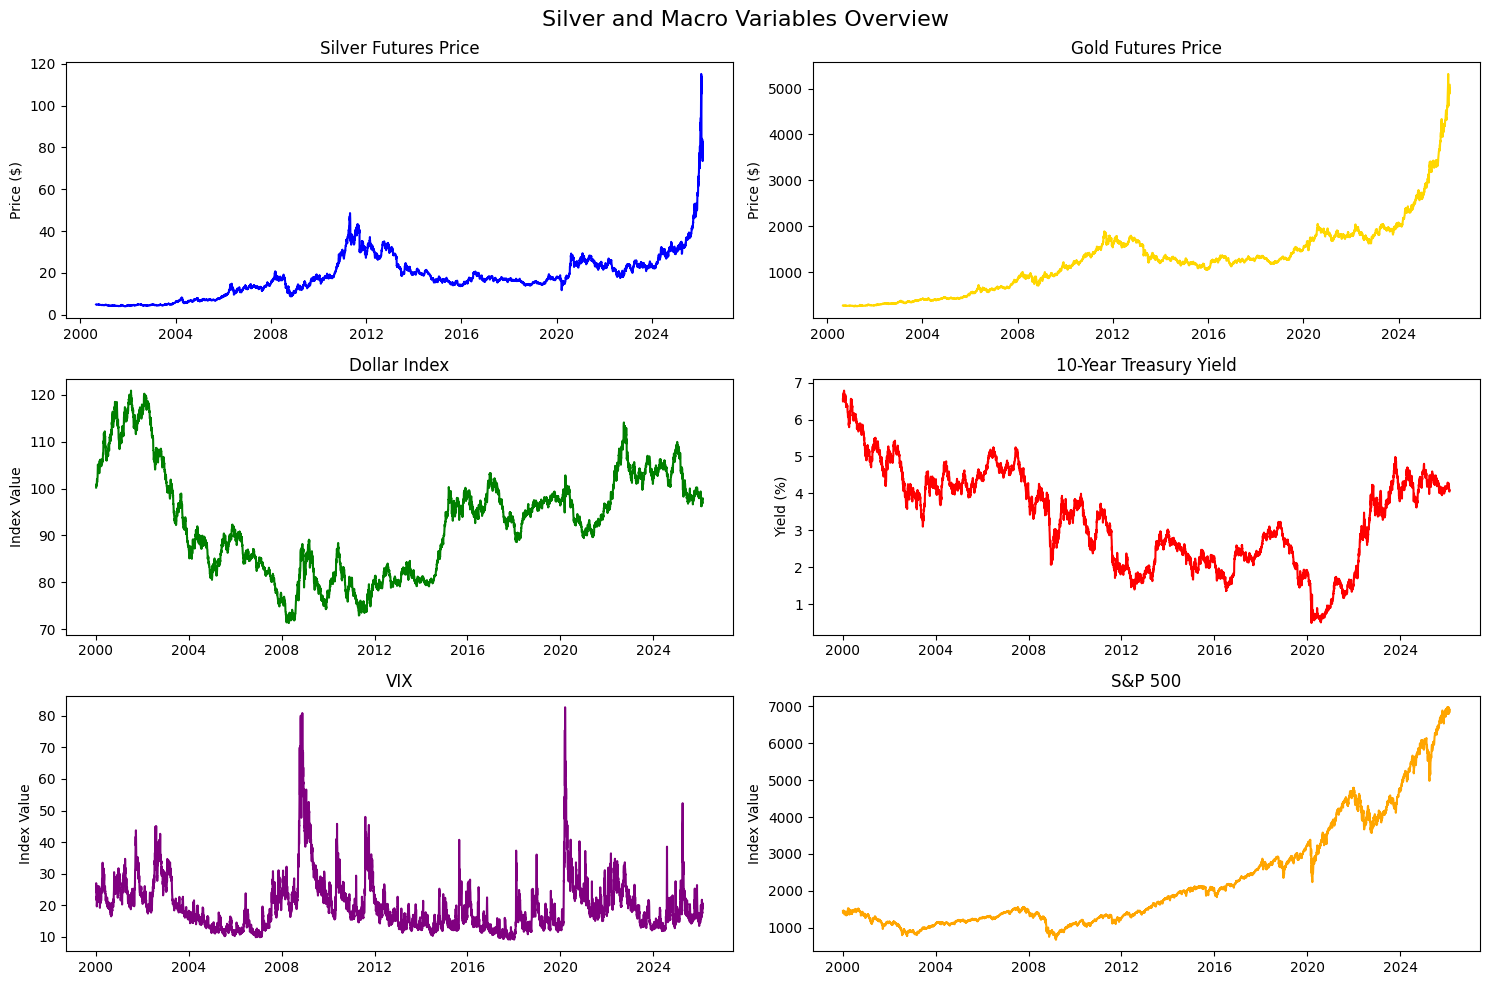

In [5]:
# Cell 5: Quick data visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Silver and Macro Variables Overview', fontsize=16)

# Silver price
axes[0, 0].plot(silver.index, silver['Close'], color='blue')
axes[0, 0].set_title('Silver Futures Price')
axes[0, 0].set_ylabel('Price ($)')

# Gold
axes[0, 1].plot(macro_data['gold'].index, macro_data['gold']['Close'], color='gold')
axes[0, 1].set_title('Gold Futures Price')
axes[0, 1].set_ylabel('Price ($)')

# Dollar Index
axes[1, 0].plot(macro_data['dollar_index'].index, macro_data['dollar_index']['Close'], color='green')
axes[1, 0].set_title('Dollar Index')
axes[1, 0].set_ylabel('Index Value')

# Interest Rate
axes[1, 1].plot(macro_data['interest_rate'].index, macro_data['interest_rate']['Close'], color='red')
axes[1, 1].set_title('10-Year Treasury Yield')
axes[1, 1].set_ylabel('Yield (%)')

# VIX
axes[2, 0].plot(macro_data['vix'].index, macro_data['vix']['Close'], color='purple')
axes[2, 0].set_title('VIX')
axes[2, 0].set_ylabel('Index Value')

# S&P 500
axes[2, 1].plot(macro_data['sp500'].index, macro_data['sp500']['Close'], color='orange')
axes[2, 1].set_title('S&P 500')
axes[2, 1].set_ylabel('Index Value')

plt.tight_layout()
plt.show()

In [6]:
# Cell 6: Data cleaning and returns calculation
df = silver.copy()

# Flatten multi-level column names from yfinance output
new_columns = []
for col in df.columns:
    if isinstance(col, tuple):
        # Join non-empty parts of the tuple with an underscore
        new_col = '_'.join(filter(None, col))
        new_columns.append(new_col)
    else:
        new_columns.append(col)
df.columns = new_columns

# Handle missing values (if any in the initial silver data) - Keep commented out for now
# df.dropna(inplace=True)

# Create log returns using the flattened 'Close_SI=F' column
df['returns'] = np.log(df['Close_SI=F'] / df['Close_SI=F'].shift(1))

# Create simple returns (for some models)
df['simple_returns'] = df['Close_SI=F'].pct_change()

# Drop first row with NaN returns after calculating returns
df.dropna(subset=['returns'], inplace=True)

print(f"Final dataset shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
df[['Close_SI=F', 'returns', 'simple_returns']].head()

Final dataset shape: (6393, 7)
Date range: 2000-08-31 00:00:00 to 2026-02-20 00:00:00


,Close_SI=F,returns,simple_returns
Date,,,
2000-08-31,5.003,0.014699,0.014807
2000-09-01,5.004,0.000200,0.000200
2000-09-05,4.998,-0.001200,-0.001199
2000-09-06,4.983,-0.003006,-0.003001
2000-09-07,4.935,-0.009679,-0.009633


In [7]:
# Cell 7: Statistical summary of returns
print("RETURNS STATISTICS:")
print("-" * 50)
print(f"Mean: {df['returns'].mean():.6f}")
print(f"Std Dev: {df['returns'].std():.6f}")
print(f"Skewness: {df['returns'].skew():.6f}")
print(f"Kurtosis: {df['returns'].kurtosis():.6f}")
print(f"Min: {df['returns'].min():.6f}")
print(f"Max: {df['returns'].max():.6f}")

# Jarque-Bera test for normality
from scipy.stats import jarque_bera
jb_stat, jb_p = jarque_bera(df['returns'].dropna())
print(f"\nJarque-Bera test p-value: {jb_p:.10f}")
print("=> Returns are NOT normally distributed" if jb_p < 0.05 else "=> Returns appear normal")

RETURNS STATISTICS:
--------------------------------------------------
Mean: 0.000440
Std Dev: 0.020847
Skewness: -1.551612
Kurtosis: 22.478674
Min: -0.376103
Max: 0.131250

Jarque-Bera test p-value: 0.0000000000
=> Returns are NOT normally distributed


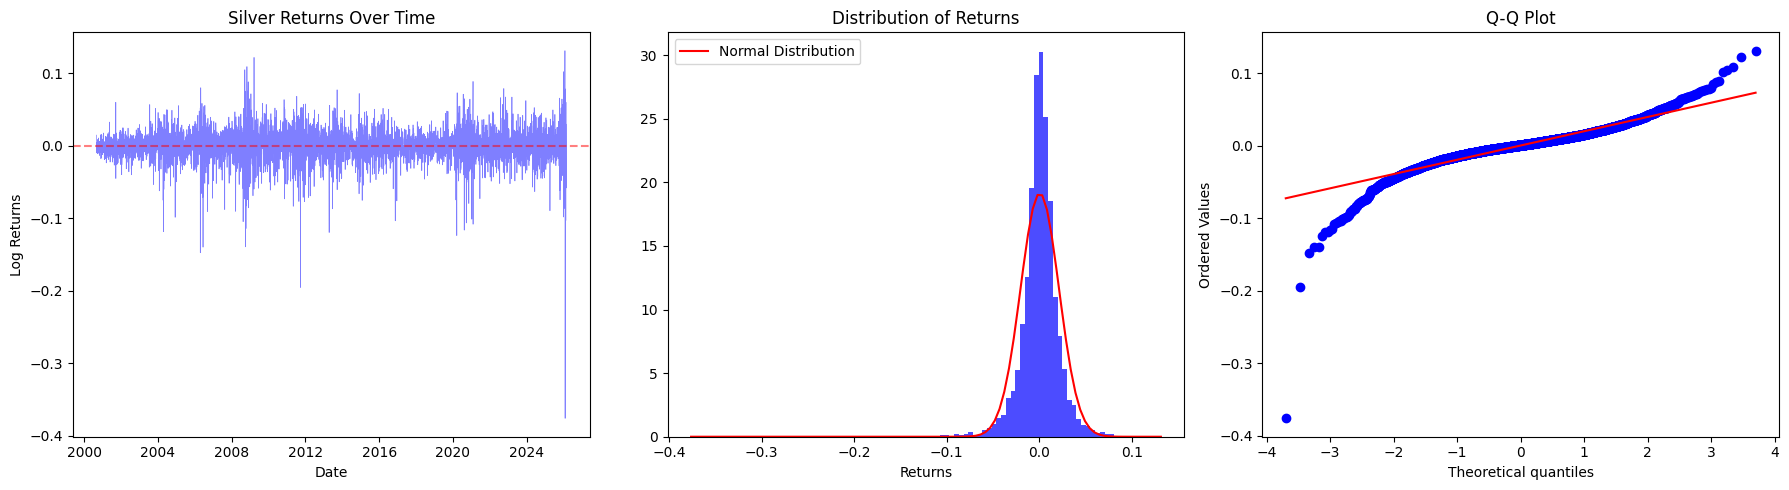

In [8]:
# Cell 8: Visualize returns distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Time series of returns
axes[0].plot(df.index, df['returns'], color='blue', alpha=0.5, linewidth=0.5)
axes[0].set_title('Silver Returns Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Log Returns')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Histogram of returns
axes[1].hist(df['returns'], bins=100, color='blue', alpha=0.7, density=True)
axes[1].set_title('Distribution of Returns')
axes[1].set_xlabel('Returns')

# Add normal distribution for comparison
x = np.linspace(df['returns'].min(), df['returns'].max(), 100)
axes[1].plot(x, stats.norm.pdf(x, df['returns'].mean(), df['returns'].std()),
             'r-', label='Normal Distribution')
axes[1].legend()

# Q-Q plot
stats.probplot(df['returns'].dropna(), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

In [9]:
# Cell 9: Realized Volatility Features
print("Creating realized volatility features...")

# Rolling realized volatility
df['rv_7'] = df['returns'].rolling(window=7).std() * np.sqrt(252)  # Annualized
df['rv_30'] = df['returns'].rolling(window=30).std() * np.sqrt(252)
df['rv_90'] = df['returns'].rolling(window=90).std() * np.sqrt(252)

# Volatility of volatility (EXTREME ADVANCED)
df['vol_of_vol'] = df['rv_30'].rolling(window=30).std()

print("Realized volatility features created:")
print(df[['rv_7', 'rv_30', 'rv_90']].describe())

Creating realized volatility features...
Realized volatility features created:
              rv_7        rv_30        rv_90
count  6387.000000  6364.000000  6304.000000
mean      0.278447     0.292772     0.297279
std       0.181301     0.141393     0.115137
min       0.027471     0.088134     0.104471
25%       0.169224     0.198715     0.215997
50%       0.237457     0.263459     0.271602
75%       0.334438     0.338947     0.346051
max       2.689177     1.498986     0.963517


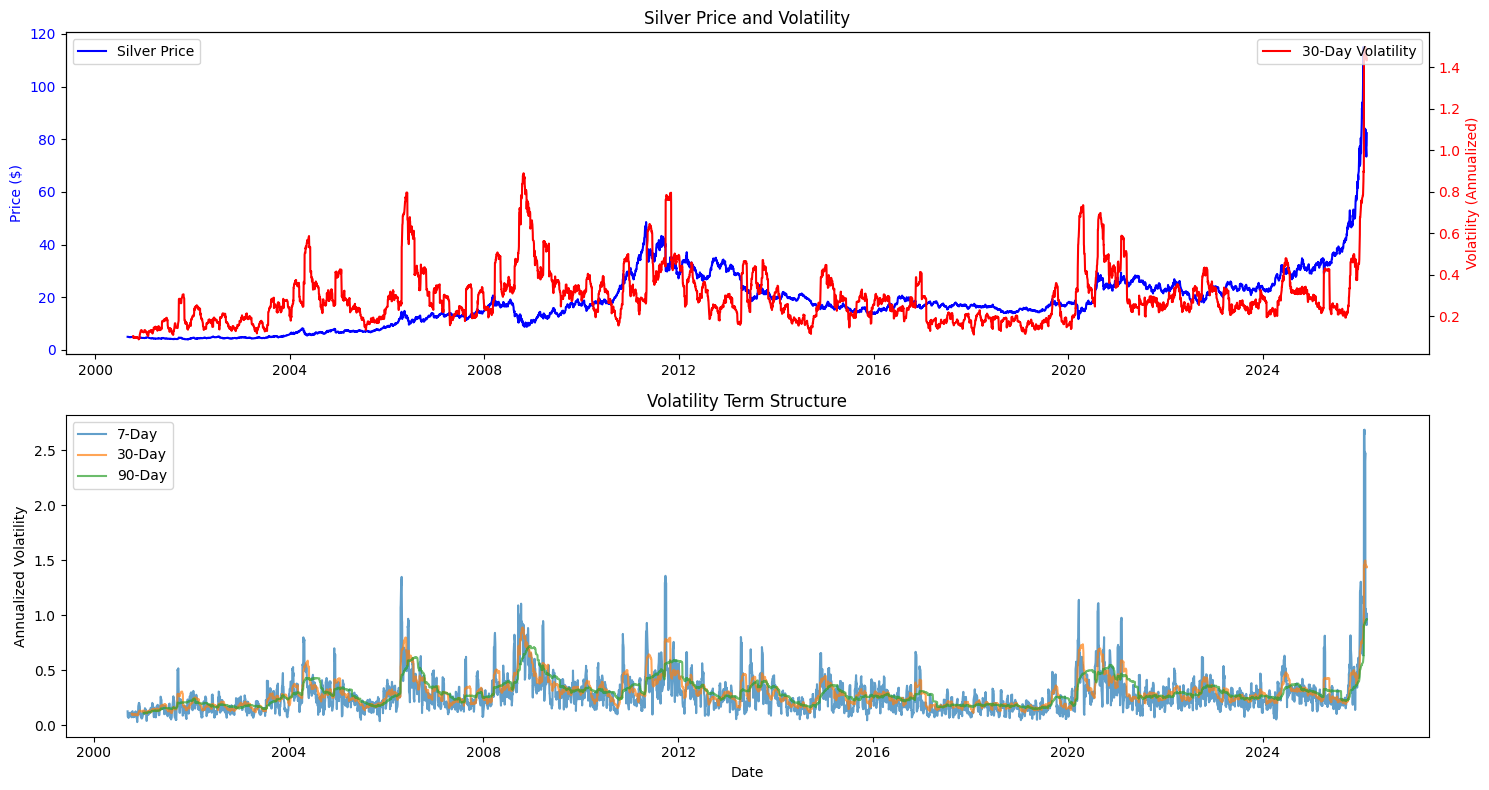

In [10]:
# Cell 10: Plot volatility clustering
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Price and volatility
ax1 = axes[0]
ax1.plot(df.index, df['Close_SI=F'], color='blue', label='Silver Price')
ax1.set_ylabel('Price ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['rv_30'], color='red', label='30-Day Volatility')
ax2.set_ylabel('Volatility (Annualized)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Silver Price and Volatility')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Volatility only
axes[1].plot(df.index, df['rv_7'], label='7-Day', alpha=0.7)
axes[1].plot(df.index, df['rv_30'], label='30-Day', alpha=0.7)
axes[1].plot(df.index, df['rv_90'], label='90-Day', alpha=0.7)
axes[1].set_title('Volatility Term Structure')
axes[1].set_ylabel('Annualized Volatility')
axes[1].legend()
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [11]:
# Cell 11: Lag Features and Momentum
print("Creating lag and momentum features...")

# Lag returns
for lag in [1, 2, 3, 5, 10]:
    df[f'lag_{lag}'] = df['returns'].shift(lag)

# Momentum features
df['momentum_5'] = df['Close_SI=F'] - df['Close_SI=F'].shift(5)
df['momentum_20'] = df['Close_SI=F'] - df['Close_SI=F'].shift(20)
df['momentum_60'] = df['Close_SI=F'] - df['Close_SI=F'].shift(60)

# Moving averages
df['ma_20'] = df['Close_SI=F'].rolling(20).mean()
df['ma_50'] = df['Close_SI=F'].rolling(50).mean()
df['ma_200'] = df['Close_SI=F'].rolling(200).mean()

print("Lag and momentum features created!")
df[['lag_1', 'lag_2', 'momentum_20', 'ma_20']].tail()

Creating lag and momentum features...
Lag and momentum features created!


,lag_1,lag_2,momentum_20,ma_20
Date,,,,
2026-02-13,-0.103142,0.043136,-14.025002,89.706601
2026-02-17,0.030055,-0.103142,-14.644005,88.974400
2026-02-18,-0.058233,0.030055,-16.696999,88.139550
2026-02-19,0.053830,-0.058233,-14.644997,87.407301
2026-02-20,0.000722,0.053830,-13.632996,86.725651


In [12]:
# Cell 12: Technical Indicators (RSI, MACD)
print("Calculating technical indicators...")

# RSI (Relative Strength Index)
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi_14'] = calculate_rsi(df['Close_SI=F'], 14)

# MACD
exp1 = df['Close_SI=F'].ewm(span=12, adjust=False).mean()
exp2 = df['Close_SI=F'].ewm(span=26, adjust=False).mean()
df['macd'] = exp1 - exp2
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
df['macd_histogram'] = df['macd'] - df['macd_signal']

print("Technical indicators created!")
print(f"RSI range: {df['rsi_14'].min():.2f} to {df['rsi_14'].max():.2f}")

Calculating technical indicators...
Technical indicators created!
RSI range: 0.78 to 98.15


Detecting volatility jumps...
Total jumps detected: 324
Jump frequency: 5.07%


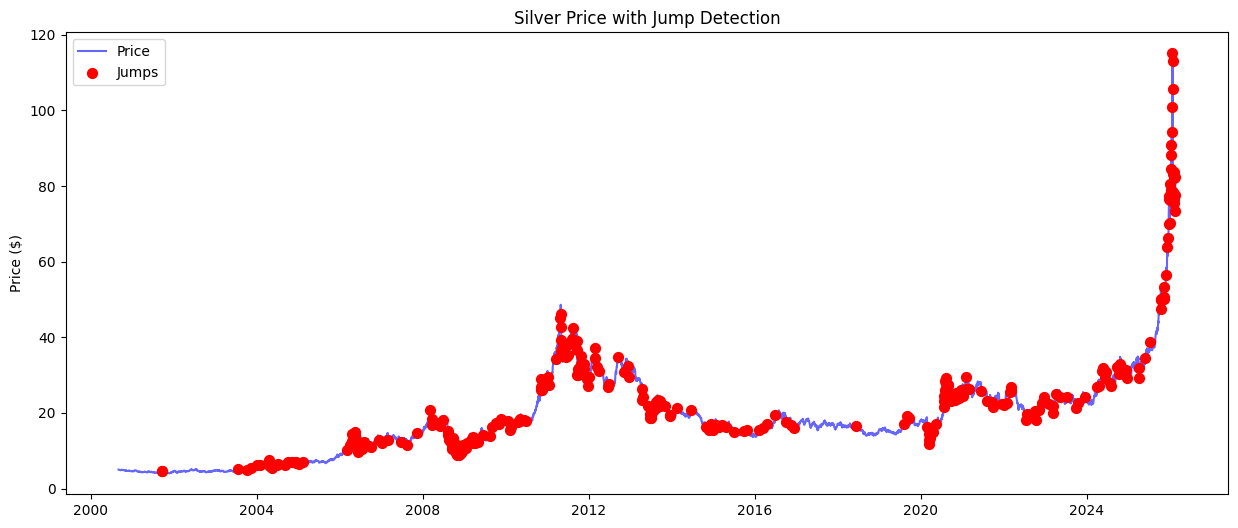

In [13]:
# Cell 13: Jump Detection (EXTREME ADVANCED)
print("Detecting volatility jumps...")

# Calculate threshold (2 standard deviations)
threshold = 2 * df['returns'].std()
df['jump'] = (abs(df['returns']) > threshold).astype(int)

# Calculate jump intensity
df['jump_intensity_30'] = df['jump'].rolling(30).sum()

print(f"Total jumps detected: {df['jump'].sum()}")
print(f"Jump frequency: {df['jump'].mean()*100:.2f}%")

# Plot jumps
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df.index, df['Close_SI=F'], color='blue', alpha=0.6, label='Price')
jump_dates = df[df['jump'] == 1].index
jump_prices = df.loc[jump_dates, 'Close_SI=F']
ax.scatter(jump_dates, jump_prices, color='red', s=50, label='Jumps', zorder=5)
ax.set_title('Silver Price with Jump Detection')
ax.set_ylabel('Price ($)')
ax.legend()
plt.show()

In [14]:
# Cell 14: Macro Feature Integration
print("Integrating macro variables...")

# Align macro data with silver data
for name, data in macro_data.items():
    df[name] = data['Close']

# Calculate macro returns
for name in macro_data.keys():
    df[f'{name}_returns'] = np.log(df[name] / df[name].shift(1))

# Flatten multi-level column names
# This ensures that column names are simple strings, compatible with LightGBM
new_columns = []
for col in df.columns:
    if isinstance(col, tuple):
        # Join non-empty parts of the tuple with an underscore
        new_col = '_'.join(filter(None, col))
        new_columns.append(new_col)
    else:
        new_columns.append(col)
df.columns = new_columns

# Correlations with silver
# Ensure the 'returns' column name is compatible after flattening
correlations = df[['returns'] + [f'{name}_returns' for name in macro_data.keys()]].corr()
print("\nCorrelations with Silver Returns:")
print(correlations['returns'].sort_values(ascending=False))

# Drop NaN values (REMOVED from here - will be handled when preparing ML dataset)
# df.dropna(inplace=True)

print(f"\nFinal feature set shape: {df.shape}")
print(f"Features include: {list(df.columns)}")

Integrating macro variables...

Correlations with Silver Returns:
returns                  1.000000
gold_returns             0.777315
sp500_returns            0.118452
interest_rate_returns   -0.040170
vix_returns             -0.098881
dollar_index_returns    -0.356694
Name: returns, dtype: float64

Final feature set shape: (6393, 38)
Features include: ['Close_SI=F', 'High_SI=F', 'Low_SI=F', 'Open_SI=F', 'Volume_SI=F', 'returns', 'simple_returns', 'rv_7', 'rv_30', 'rv_90', 'vol_of_vol', 'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_10', 'momentum_5', 'momentum_20', 'momentum_60', 'ma_20', 'ma_50', 'ma_200', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'jump', 'jump_intensity_30', 'gold', 'dollar_index', 'interest_rate', 'vix', 'sp500', 'gold_returns', 'dollar_index_returns', 'interest_rate_returns', 'vix_returns', 'sp500_returns']


In [15]:
# Cell 15: EWMA Model (RiskMetrics)
print("Building EWMA model...")

# EWMA volatility (lambda = 0.94 is standard for RiskMetrics)
lambda_param = 0.94
df['ewma_var'] = 0
df['ewma_vol'] = 0

# Initialize with first available return
df.loc[df.index[0], 'ewma_var'] = df.loc[df.index[0], 'returns']**2

# Calculate EWMA variance
for i in range(1, len(df)):
    df.loc[df.index[i], 'ewma_var'] = (lambda_param * df.loc[df.index[i-1], 'ewma_var'] +
                                        (1 - lambda_param) * df.loc[df.index[i], 'returns']**2)

df['ewma_vol'] = np.sqrt(df['ewma_var'] * 252)  # Annualized

print("EWMA model complete!")
print(f"Current EWMA volatility: {df['ewma_vol'].iloc[-1]:.4f}")

Building EWMA model...
EWMA model complete!
Current EWMA volatility: 1.2990


In [16]:
# Cell 16: GARCH(1,1) Model
print("Building GARCH(1,1) model...")

# Fit GARCH model
garch_model = arch_model(df['returns'] * 100, vol='Garch', p=1, q=1, dist='normal')
garch_result = garch_model.fit(disp='off')

print(garch_result.summary())

# Get conditional volatility
df['garch_vol'] = garch_result.conditional_volatility / 100  # Scale back
df['garch_vol_annualized'] = df['garch_vol'] * np.sqrt(252)

# Forecast
garch_forecast = garch_result.forecast(horizon=5)
print(f"\n5-day volatility forecast: {np.sqrt(garch_forecast.variance.iloc[-1] * 252) / 100}")

Building GARCH(1,1) model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12843.2
Distribution:                  Normal   AIC:                           25694.4
Method:            Maximum Likelihood   BIC:                           25721.5
                                        No. Observations:                 6393
Date:                Sun, Feb 22 2026   Df Residuals:                     6392
Time:                        07:13:31   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.9117e-03  2.0

In [17]:
# Cell 17: Advanced GARCH Models (EGARCH, GJR-GARCH, FIGARCH)
print("Building advanced GARCH models...")

# EGARCH (asymmetric effects)
egarch_model = arch_model(df['returns'] * 100, vol='EGarch', p=1, q=1, o=1)
egarch_result = egarch_model.fit(disp='off')
df['egarch_vol'] = egarch_result.conditional_volatility / 100

print("\nEGARCH Model (captures leverage effect):")
print(egarch_result.summary())

# GJR-GARCH (threshold GARCH)
gjrgarch_model = arch_model(df['returns'] * 100, vol='GARCH', p=1, q=1, o=1)  # o=1 for threshold
gjrgarch_result = gjrgarch_model.fit(disp='off')
df['gjrgarch_vol'] = gjrgarch_result.conditional_volatility / 100

print("\nGJR-GARCH Model (captures asymmetry):")
print(f"Gamma parameter (asymmetry): {gjrgarch_result.params.get('gamma[1]', 'N/A')}")

Building advanced GARCH models...

EGARCH Model (captures leverage effect):
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -12826.5
Distribution:                  Normal   AIC:                           25663.0
Method:            Maximum Likelihood   BIC:                           25696.8
                                        No. Observations:                 6393
Date:                Sun, Feb 22 2026   Df Residuals:                     6392
Time:                        07:13:32   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------

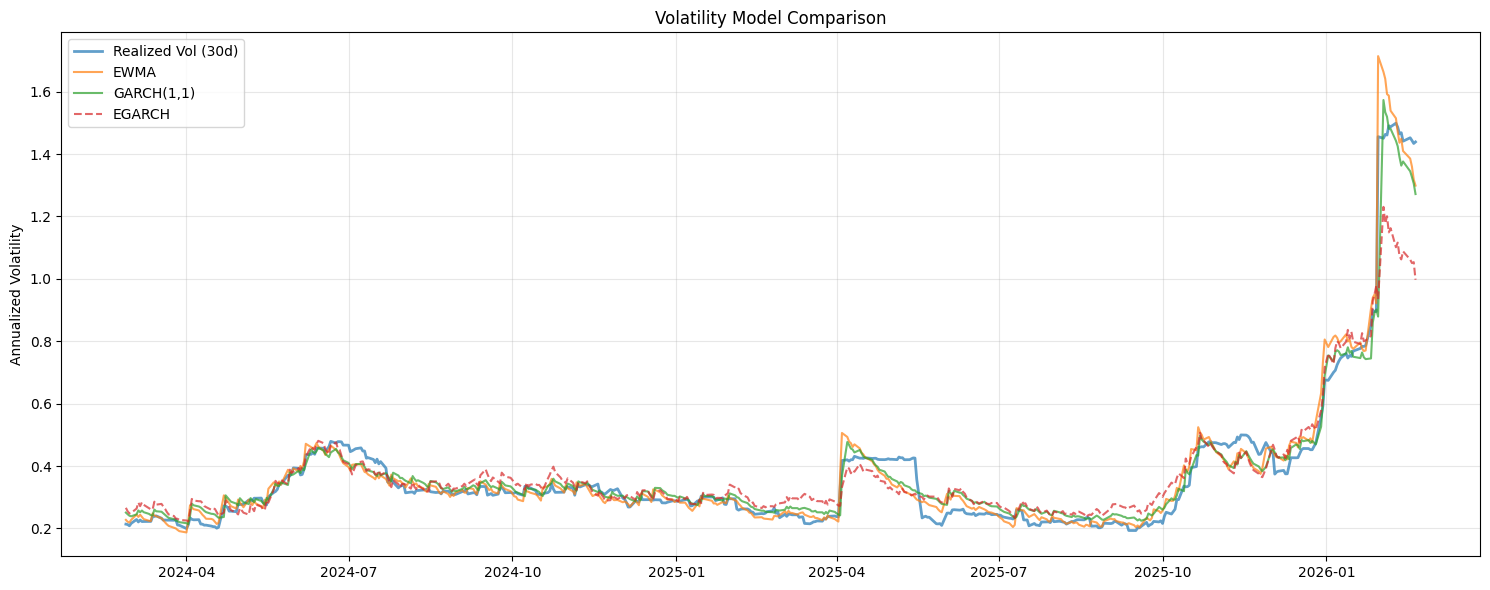

MODEL PERFORMANCE (RMSE vs Realized Vol):
ewma_vol: RMSE = 0.0334
garch_vol_annualized: RMSE = 0.0375
egarch_vol_annualized: RMSE = 0.0497


In [18]:
# Cell 18: Compare volatility models
fig, ax = plt.subplots(figsize=(15, 6))

# Plot recent period (last 500 days)
recent_data = df.iloc[-500:]

ax.plot(recent_data.index, recent_data['rv_30'], label='Realized Vol (30d)', linewidth=2, alpha=0.7)
ax.plot(recent_data.index, recent_data['ewma_vol'], label='EWMA', linewidth=1.5, alpha=0.7)
ax.plot(recent_data.index, recent_data['garch_vol_annualized'], label='GARCH(1,1)', linewidth=1.5, alpha=0.7)

if 'egarch_vol' in df.columns:
    ax.plot(recent_data.index, recent_data['egarch_vol'] * np.sqrt(252),
            label='EGARCH', linewidth=1.5, alpha=0.7, linestyle='--')

ax.set_title('Volatility Model Comparison')
ax.set_ylabel('Annualized Volatility')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model performance metrics
print("MODEL PERFORMANCE (RMSE vs Realized Vol):")
from sklearn.metrics import mean_squared_error

models = ['ewma_vol', 'garch_vol_annualized']
if 'egarch_vol' in df.columns:
    # Create the annualized EGARCH volatility column
    df['egarch_vol_annualized'] = df['egarch_vol'] * np.sqrt(252)
    # Append the name of the new column to the models list
    models.append('egarch_vol_annualized')

for model in models:
    # The condition 'model in df.columns or model in df.columns' is redundant, simplified to 'model in df.columns'
    if model in df.columns:
        # 'col' will now directly be the name of the annualized column if it exists
        col = model
        # Ensure we only compare non-NaN values
        # Also, ensure 'rv_30' is properly aligned and has no NaNs for comparison
        # A common practice is to drop NaNs across all relevant columns before calculation
        comparison_df = pd.DataFrame({'rv_30': df['rv_30'], 'model_vol': df[col]}).dropna()

        if not comparison_df.empty:
            rmse = np.sqrt(mean_squared_error(comparison_df['rv_30'], comparison_df['model_vol']))
            print(f"{col}: RMSE = {rmse:.4f}")
        else:
            print(f"Could not calculate RMSE for {col} due to insufficient non-NaN data.")


In [19]:
# Cell 19: Prepare ML Dataset
print("Preparing dataset for ML models...")

# Define features and target
feature_cols = ['returns', 'rv_7', 'rv_30', 'vol_of_vol', 'lag_1', 'lag_2', 'lag_3',
                'momentum_5', 'momentum_20', 'rsi_14', 'macd', 'jump', 'jump_intensity_30']

# Add macro features
for name in macro_data.keys():
    feature_cols.append(f'{name}_returns')

# Target: future 30-day realized volatility (shifted back)
df['target_vol'] = df['rv_30'].shift(-30)

# Drop NaN values
ml_data = df[feature_cols + ['target_vol']].dropna()

X = ml_data[feature_cols]
y = ml_data['target_vol']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {feature_cols}")

Preparing dataset for ML models...
Features shape: (6280, 18)
Target shape: (6280,)

Features used: ['returns', 'rv_7', 'rv_30', 'vol_of_vol', 'lag_1', 'lag_2', 'lag_3', 'momentum_5', 'momentum_20', 'rsi_14', 'macd', 'jump', 'jump_intensity_30', 'gold_returns', 'dollar_index_returns', 'interest_rate_returns', 'vix_returns', 'sp500_returns']


In [20]:
# Cell 20: Train/Test Split
# Split data (time series - use chronological split)
split_date = ml_data.index[int(len(ml_data) * 0.8)]
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

print(f"Training data: {X_train.shape[0]} samples")
print(f"Test data: {X_test.shape[0]} samples")
print(f"Split date: {split_date}")

Training data: 5024 samples
Test data: 1256 samples
Split date: 2021-01-05 00:00:00


In [21]:
# Cell 21: Random Forest Model
print("Training Random Forest model...")

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest R²: {rf_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

Training Random Forest model...
Random Forest RMSE: 0.1378
Random Forest R²: 0.2300

Top 10 Important Features:
                  feature  importance
2                   rv_30    0.317957
12      jump_intensity_30    0.242419
10                   macd    0.148552
3              vol_of_vol    0.080250
9                  rsi_14    0.032483
1                    rv_7    0.029873
8             momentum_20    0.028161
17          sp500_returns    0.027904
7              momentum_5    0.026985
15  interest_rate_returns    0.020397


In [22]:
# Cell 22: XGBoost Model
print("Training XGBoost model...")

xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost R²: {xgb_r2:.4f}")

# Feature importance
xgb_importance = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features (XGBoost):")
print(xgb_importance_df.head(10))

Training XGBoost model...
XGBoost RMSE: 0.1372
XGBoost R²: 0.2372

Top 10 Important Features (XGBoost):
                  feature  importance
12      jump_intensity_30    0.406864
2                   rv_30    0.147454
10                   macd    0.095385
3              vol_of_vol    0.051968
17          sp500_returns    0.049373
7              momentum_5    0.041042
9                  rsi_14    0.038343
8             momentum_20    0.031360
15  interest_rate_returns    0.027683
1                    rv_7    0.023238


In [23]:
# Cell 23: LightGBM Model
print("Training LightGBM model...")

lgb_model = lgb.LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict(X_test)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)

print(f"LightGBM RMSE: {lgb_rmse:.4f}")
print(f"LightGBM R²: {lgb_r2:.4f}")

Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4096
[LightGBM] [Info] Number of data points in the train set: 5024, number of used features: 18
[LightGBM] [Info] Start training from score 0.289600
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

ML MODEL COMPARISON:
--------------------------------------------------
Model           RMSE       R²        
--------------------------------------------------
Random Forest   0.1378      0.2300
XGBoost         0.1372      0.2372
LightGBM        0.1355      0.2552


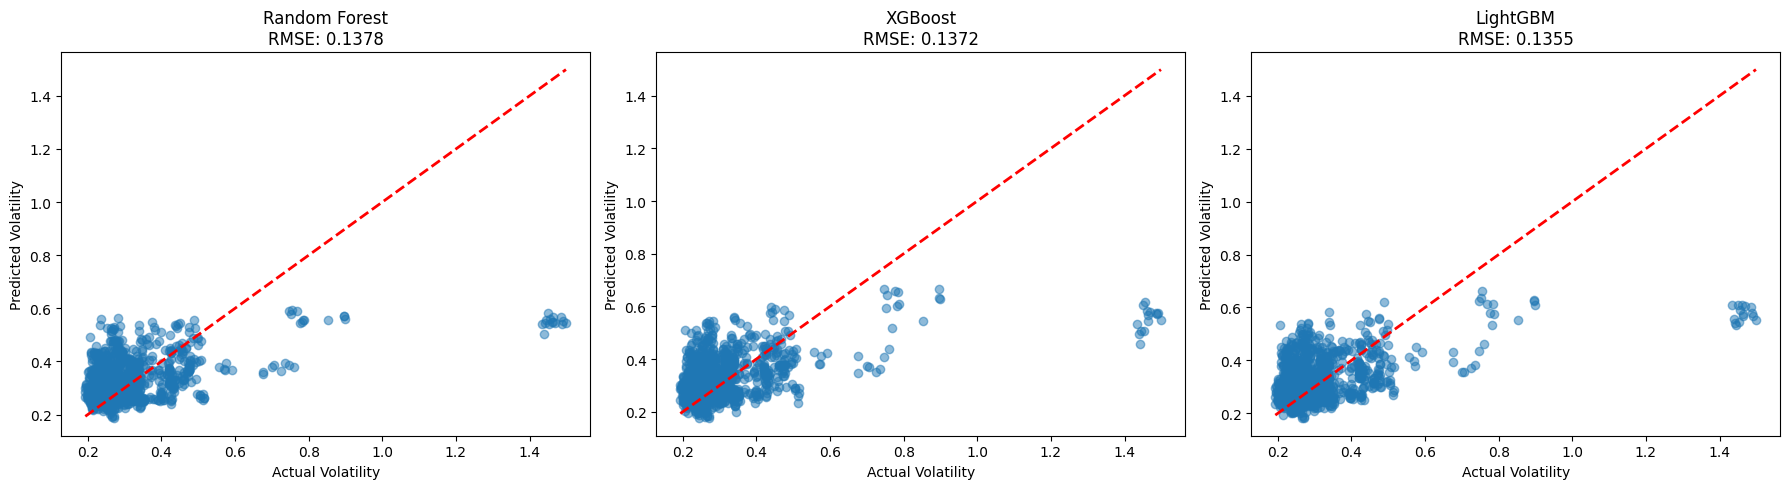

In [24]:
# Cell 24: Compare ML Models
print("ML MODEL COMPARISON:")
print("-" * 50)
print(f"{'Model':<15} {'RMSE':<10} {'R²':<10}")
print("-" * 50)
print(f"{'Random Forest':<15} {rf_rmse:.4f}      {rf_r2:.4f}")
print(f"{'XGBoost':<15} {xgb_rmse:.4f}      {xgb_r2:.4f}")
print(f"{'LightGBM':<15} {lgb_rmse:.4f}      {lgb_r2:.4f}")

# Plot predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [('Random Forest', rf_pred), ('XGBoost', xgb_pred), ('LightGBM', lgb_pred)]

for i, (name, pred) in enumerate(models):
    axes[i].scatter(y_test, pred, alpha=0.5)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Volatility')
    axes[i].set_ylabel('Predicted Volatility')
    axes[i].set_title(f'{name}\nRMSE: {np.sqrt(mean_squared_error(y_test, pred)):.4f}')

plt.tight_layout()
plt.show()

In [25]:
# Cell 25: Prepare Data for LSTM
print("Preparing data for LSTM...")

# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(X, y, seq_length=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# Split
split_idx = int(len(X_seq) * 0.8)
X_train_seq = X_seq[:split_idx]
X_test_seq = X_seq[split_idx:]
y_train_seq = y_seq[:split_idx]
y_test_seq = y_seq[split_idx:]

print(f"LSTM input shape: {X_train_seq.shape}")
print(f"LSTM target shape: {y_train_seq.shape}")

Preparing data for LSTM...
LSTM input shape: (5000, 30, 18)
LSTM target shape: (5000, 1)


Building LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        13,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,301 (137.89 KB)

 Trainable params: 35,301 (137.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0090 - mae: 0.0681 - val_loss: 0.0122 - val_mae: 0.0777
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - mae: 0.0532 - val_loss: 0.0124 - val_mae: 0.0779
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0054 - mae: 0.0511 - val_loss: 0.0125 - val_mae: 0.0731
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0051 - mae: 0.0497 - val_loss: 0.0122 - val_mae: 0.0810
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - mae: 0.0501 - val_loss: 0.0128 - val_mae: 0.0780
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - mae: 0.0485 - val_loss: 0.0120 - val_mae: 0.0727
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - mae: 0.0483 - val_loss: 0.0136 - val_mae: 0.0759
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - mae: 0.0464 - val_loss: 0.0128 - val_mae: 0.0803
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - 

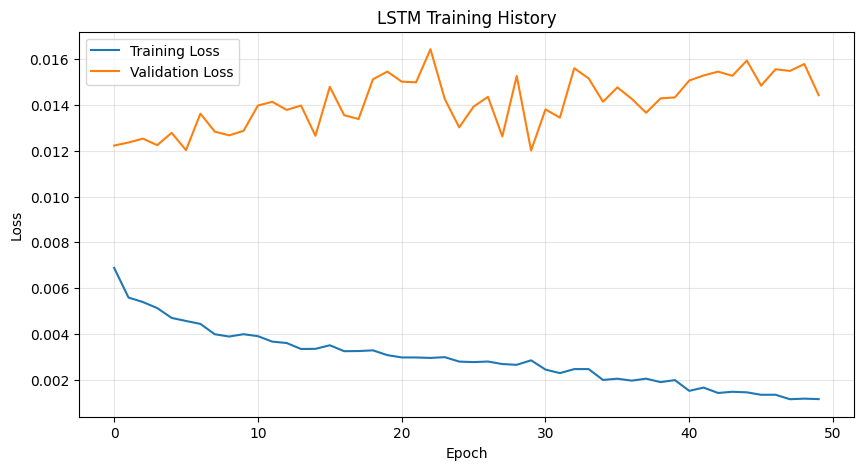

In [26]:
# Cell 26: Build LSTM Model
print("Building LSTM model...")

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[1])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
lstm_model.summary()

# Train
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Plot training history
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('LSTM Training History')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [27]:
# Cell 27: Build GRU Model
print("Building GRU model...")

gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(seq_length, X.shape[1])),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
gru_model.summary()

# Train
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Building GRU model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 50)         │        10,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,101 (105.86 KB)

 Trainable params: 27,101 (105.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0130 - mae: 0.0827 - val_loss: 0.0125 - val_mae: 0.0790
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - mae: 0.0527 - val_loss: 0.0122 - val_mae: 0.0742
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - mae: 0.0512 - val_loss: 0.0123 - val_mae: 0.0736
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - mae: 0.0519 - val_loss: 0.0135 - val_mae: 0.0744
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - mae: 0.0527 - val_loss: 0.0130 - val_mae: 0.0737
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - mae: 0.0506 - val_loss: 0.0122 - val_mae: 0.0752
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0052 - mae: 0.0510 - val_loss: 0.0123 - val_mae: 0.0783
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0053 - mae: 0.0512 - val_loss: 0.0126 - val_mae: 0.0762
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step -

In [28]:
# Cell 28: LSTM Predictions and Evaluation
print("Evaluating LSTM model...")

# Make predictions
lstm_pred_scaled = lstm_model.predict(X_test_seq)
lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred))
lstm_r2 = r2_score(y_test_actual, lstm_pred)

print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM R²: {lstm_r2:.4f}")

# GRU predictions
gru_pred_scaled = gru_model.predict(X_test_seq)
gru_pred = scaler_y.inverse_transform(gru_pred_scaled)
gru_rmse = np.sqrt(mean_squared_error(y_test_actual, gru_pred))
gru_r2 = r2_score(y_test_actual, gru_pred)

print(f"GRU RMSE: {gru_rmse:.4f}")
print(f"GRU R²: {gru_r2:.4f}")

Evaluating LSTM model...
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
LSTM RMSE: 0.1513
LSTM R²: 0.0673
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
GRU RMSE: 0.1441
GRU R²: 0.1542


Creating ensemble model combining GARCH, ML, and LSTM...
ENSEMBLE MODEL PERFORMANCE:
--------------------------------------------------
XGBoost RMSE: 0.1372
LSTM RMSE: 0.1513
Ensemble RMSE: 0.1360
Ensemble R²: 0.2464
Ensemble improvement: 0.84%


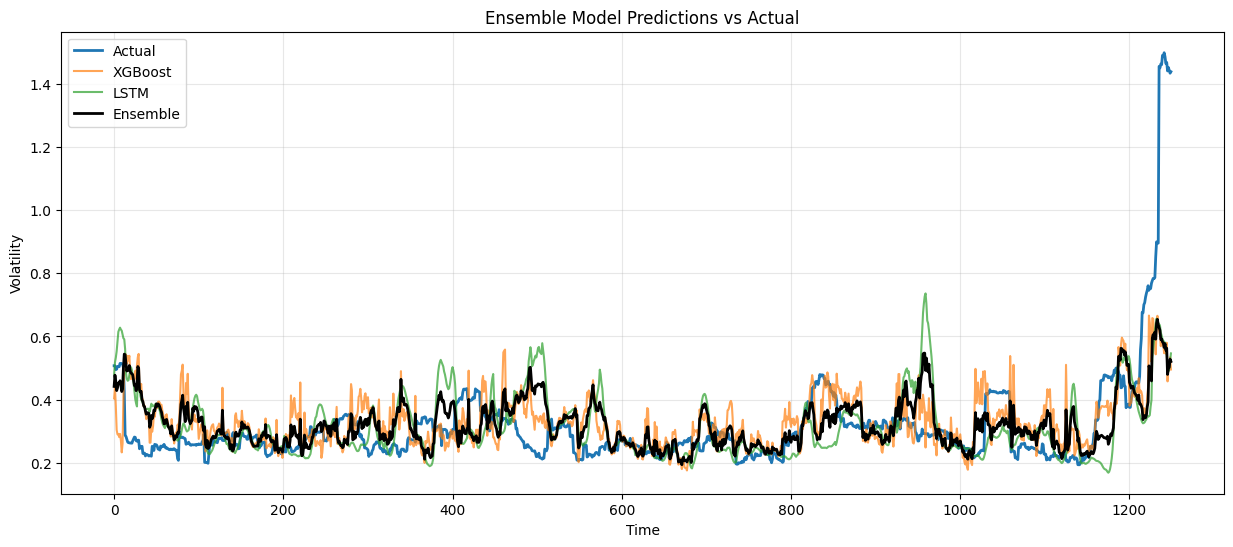

In [29]:
# Cell 29: Create Ensemble Model (EXTREME ADVANCED)
print("Creating ensemble model combining GARCH, ML, and LSTM...")

# Align predictions for ensemble
# Note: This requires aligning the indices properly
min_length = min(len(y_test), len(lstm_pred), len(xgb_pred))

# Use the last 'min_length' predictions
ensemble_pred = (xgb_pred[-min_length:] + lstm_pred[-min_length:].flatten()) / 2
ensemble_actual = y_test[-min_length:].values

ensemble_rmse = np.sqrt(mean_squared_error(ensemble_actual, ensemble_pred))
ensemble_r2 = r2_score(ensemble_actual, ensemble_pred)

print("ENSEMBLE MODEL PERFORMANCE:")
print("-" * 50)
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"Ensemble R²: {ensemble_r2:.4f}")
print(f"Ensemble improvement: {(xgb_rmse - ensemble_rmse)/xgb_rmse*100:.2f}%")

# Plot ensemble vs individual models
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(ensemble_actual, label='Actual', linewidth=2)
ax.plot(xgb_pred[-min_length:], label='XGBoost', alpha=0.7)
ax.plot(lstm_pred[-min_length:].flatten(), label='LSTM', alpha=0.7)
ax.plot(ensemble_pred, label='Ensemble', linewidth=2, color='black')

ax.set_title('Ensemble Model Predictions vs Actual')
ax.set_xlabel('Time')
ax.set_ylabel('Volatility')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

In [30]:
# Cell 30: Black-Scholes Model Implementation
print("Implementing Black-Scholes model...")

def black_scholes_price(S, K, T, r, sigma, option_type='c'):
    """
    Calculate Black-Scholes option price
    S: Spot price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free rate
    sigma: Volatility
    option_type: 'c' for call, 'p' for put
    """
    from scipy.stats import norm

    d1 = (np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'c':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

# Example calculation
S = df['Close_SI=F'].iloc[-1]  # Current silver price
K = S * 1.1  # 10% OTM call
T = 30/365  # 30 days
r = 0.05  # 5% risk-free rate
sigma = df['rv_30'].iloc[-1]  # Current volatility

call_price = black_scholes_price(S, K, T, r, sigma, 'c')
put_price = black_scholes_price(S, K, T, r, sigma, 'p')

print(f"Current Silver Price: ${S:.2f}")
print(f"Strike Price: ${K:.2f}")
print(f"Time to Maturity: {T*365:.0f} days")
print(f"Risk-Free Rate: {r*100:.1f}%")
print(f"Volatility: {sigma*100:.2f}%")
print("-" * 50)
print(f"Call Option Price: ${call_price:.4f}")
print(f"Put Option Price: ${put_price:.4f}")

Implementing Black-Scholes model...
Current Silver Price: $82.34
Strike Price: $90.58
Time to Maturity: 30 days
Risk-Free Rate: 5.0%
Volatility: 143.89%
--------------------------------------------------
Call Option Price: $10.5051
Put Option Price: $18.3679


In [31]:
# Cell 31: Greeks Calculation
print("Calculating option Greeks...")

def calculate_greeks(S, K, T, r, sigma, option_type='c'):
    """
    Calculate all option Greeks
    """
    from scipy.stats import norm

    d1 = (np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Delta
    if option_type == 'c':
        delta = norm.cdf(d1)
    else:
        delta = norm.cdf(d1) - 1

    # Gamma (same for calls and puts)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))

    # Theta
    if option_type == 'c':
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) -
                 r * K * np.exp(-r * T) * norm.cdf(d2))
    else:
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) +
                 r * K * np.exp(-r * T) * norm.cdf(-d2))

    # Vega (same for calls and puts)
    vega = S * norm.pdf(d1) * np.sqrt(T)

    # Rho
    if option_type == 'c':
        rho = K * T * np.exp(-r * T) * norm.cdf(d2)
    else:
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2)

    return {
        'delta': delta,
        'gamma': gamma,
        'theta': theta / 365,  # Daily theta
        'vega': vega / 100,    # Per 1% change in vol
        'rho': rho / 100        # Per 1% change in rate
    }

greeks = calculate_greeks(S, K, T, r, sigma, 'c')

print("CALL OPTION GREEKS:")
print("-" * 50)
for greek, value in greeks.items():
    print(f"{greek.capitalize()}: {value:.6f}")

Calculating option Greeks...
CALL OPTION GREEKS:
--------------------------------------------------
Delta: 0.494090
Gamma: 0.011743
Theta: -0.229968
Vega: 0.094168
Rho: 0.024805


Creating option chain visualization...


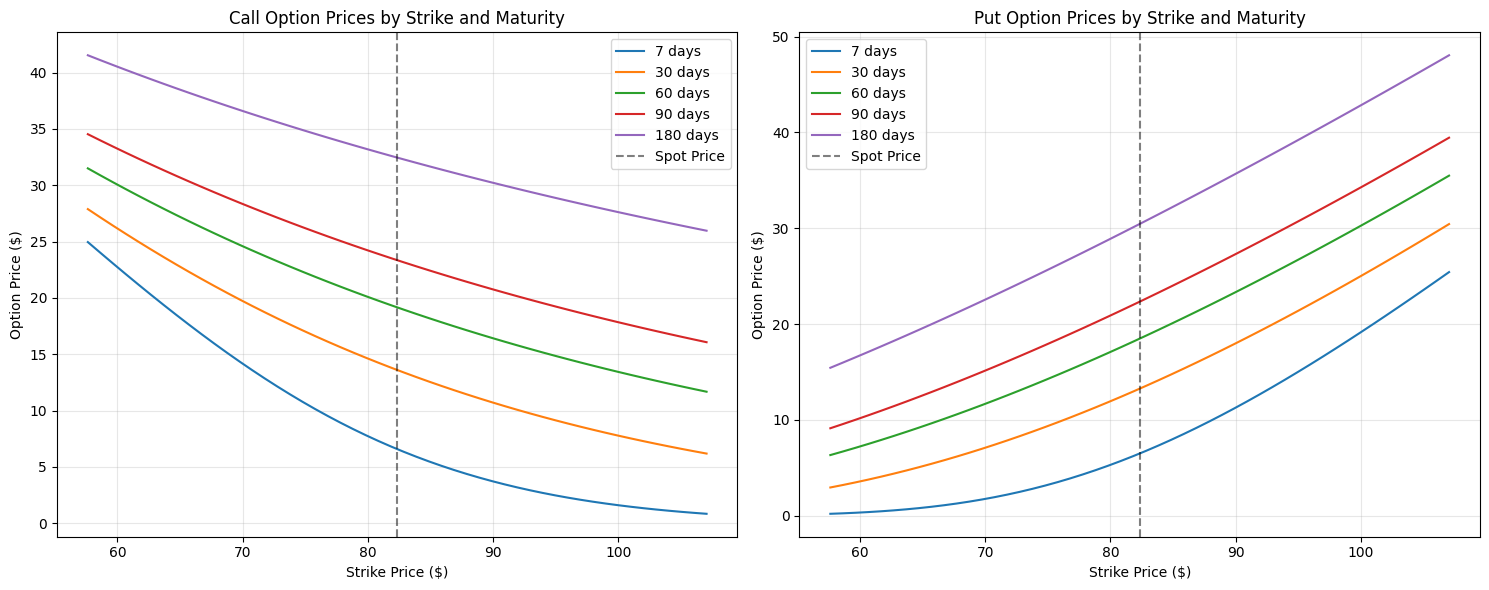

In [32]:
# Cell 32: Option Chain Visualization
print("Creating option chain visualization...")

# Create option chain for different strikes and maturities
strikes = np.linspace(S * 0.7, S * 1.3, 50)
maturities = [7, 30, 60, 90, 180]  # days

# Calculate prices for different strikes and maturities
call_prices = np.zeros((len(maturities), len(strikes)))
put_prices = np.zeros((len(maturities), len(strikes)))

for i, T_days in enumerate(maturities):
    T_years = T_days / 365
    for j, K in enumerate(strikes):
        call_prices[i, j] = black_scholes_price(S, K, T_years, r, sigma, 'c')
        put_prices[i, j] = black_scholes_price(S, K, T_years, r, sigma, 'p')

# Plot option chain
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Call options
for i, T_days in enumerate(maturities):
    axes[0].plot(strikes, call_prices[i, :], label=f'{T_days} days')
axes[0].axvline(x=S, color='black', linestyle='--', alpha=0.5, label='Spot Price')
axes[0].set_xlabel('Strike Price ($)')
axes[0].set_ylabel('Option Price ($)')
axes[0].set_title('Call Option Prices by Strike and Maturity')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Put options
for i, T_days in enumerate(maturities):
    axes[1].plot(strikes, put_prices[i, :], label=f'{T_days} days')
axes[1].axvline(x=S, color='black', linestyle='--', alpha=0.5, label='Spot Price')
axes[1].set_xlabel('Strike Price ($)')
axes[1].set_ylabel('Option Price ($)')
axes[1].set_title('Put Option Prices by Strike and Maturity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
# Cell 33: Implied Volatility Calculation
print("Calculating implied volatility...")

def implied_volatility(market_price, S, K, T, r, option_type='c'):
    """
    Calculate implied volatility using Newton-Raphson method
    """
    max_iter = 100
    precision = 1e-5
    sigma = 0.5  # Initial guess

    for i in range(max_iter):
        price = black_scholes_price(S, K, T, r, sigma, option_type)
        vega = calculate_greeks(S, K, T, r, sigma, option_type)['vega'] * 100  # Scale back

        if abs(price - market_price) < precision:
            return sigma

        if vega == 0:
            return np.nan

        sigma = sigma - (price - market_price) / vega

        # Keep sigma positive
        sigma = max(sigma, 0.001)

    return sigma

# Example: Calculate IV for a hypothetical option
market_call_price = 2.5  # Hypothetical market price
iv = implied_volatility(market_call_price, S, K, T, r, 'c')

print(f"Market Call Price: ${market_call_price}")
print(f"Calculated Implied Volatility: {iv*100:.2f}%")
print(f"Historical Volatility: {sigma*100:.2f}%")
print(f"IV - HV Spread: {(iv - sigma)*100:.2f}%")

Calculating implied volatility...
Market Call Price: $2.5
Calculated Implied Volatility: 97.47%
Historical Volatility: 143.89%
IV - HV Spread: -46.42%


Implementing Monte Carlo option pricing...
Monte Carlo Call Price: $6.2358
Black-Scholes Call Price: $10.5051
Difference: $4.269299
95% Confidence Interval: [$5.8695, $6.6020]


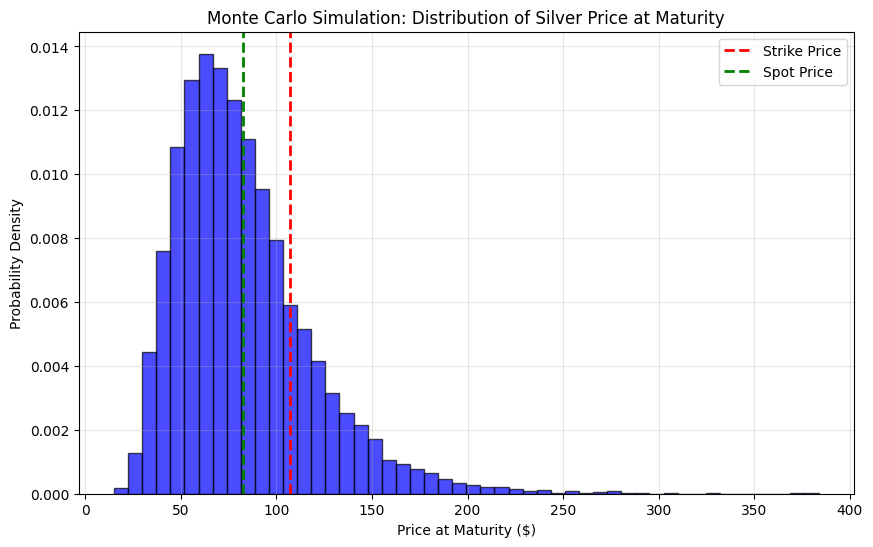

In [34]:
# Cell 34: Monte Carlo Option Pricing
print("Implementing Monte Carlo option pricing...")

def monte_carlo_option_price(S, K, T, r, sigma, option_type='c', n_sims=10000):
    """
    Price option using Monte Carlo simulation
    """
    np.random.seed(42)

    # Simulate price paths
    dt = T
    n_steps = 1  # Simplified: single step to maturity

    # Generate random paths
    z = np.random.standard_normal(n_sims)
    S_T = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

    # Calculate payoff
    if option_type == 'c':
        payoff = np.maximum(S_T - K, 0)
    else:
        payoff = np.maximum(K - S_T, 0)

    # Discount to present value
    price = np.exp(-r * T) * np.mean(payoff)

    # Confidence interval
    std_error = np.std(payoff) / np.sqrt(n_sims)
    ci_lower = price - 1.96 * std_error
    ci_upper = price + 1.96 * std_error

    return price, ci_lower, ci_upper, S_T

# Run Monte Carlo
mc_price, mc_ci_lower, mc_ci_upper, paths = monte_carlo_option_price(S, K, T, r, sigma, 'c')

print(f"Monte Carlo Call Price: ${mc_price:.4f}")
print(f"Black-Scholes Call Price: ${call_price:.4f}")
print(f"Difference: ${abs(mc_price - call_price):.6f}")
print(f"95% Confidence Interval: [${mc_ci_lower:.4f}, ${mc_ci_upper:.4f}]")

# Plot distribution of final prices
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(paths, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(x=K, color='red', linestyle='--', linewidth=2, label='Strike Price')
ax.axvline(x=S, color='green', linestyle='--', linewidth=2, label='Spot Price')
ax.set_xlabel('Price at Maturity ($)')
ax.set_ylabel('Probability Density')
ax.set_title('Monte Carlo Simulation: Distribution of Silver Price at Maturity')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [35]:
# Cell 35: Heston Stochastic Volatility Model (EXTREME ADVANCED)
print("Implementing Heston Stochastic Volatility Model...")

def heston_model_simulation(S0, v0, kappa, theta, xi, rho, r, T, K, n_sims=10000, n_steps=252):
    """
    Simulate Heston stochastic volatility model
    S0: Initial price
    v0: Initial variance
    kappa: Mean reversion speed
    theta: Long-term variance
    xi: Volatility of volatility
    rho: Correlation between price and volatility
    r: Risk-free rate
    T: Time to maturity
    K: Strike price
    """
    dt = T / n_steps

    # Initialize arrays
    S = np.zeros((n_sims, n_steps + 1))
    v = np.zeros((n_sims, n_steps + 1))
    S[:, 0] = S0
    v[:, 0] = v0

    # Generate correlated random numbers
    for t in range(n_steps):
        # Generate correlated Brownian motions
        z1 = np.random.standard_normal(n_sims)
        z2 = np.random.standard_normal(n_sims)
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2

        # Ensure variance stays positive (full truncation scheme)
        v[:, t+1] = v[:, t] + kappa * (theta - np.maximum(v[:, t], 0)) * dt + xi * np.sqrt(np.maximum(v[:, t], 0)) * np.sqrt(dt) * w2
        v[:, t+1] = np.maximum(v[:, t+1], 0)

        # Update price
        S[:, t+1] = S[:, t] * np.exp((r - 0.5 * v[:, t]) * dt + np.sqrt(v[:, t]) * np.sqrt(dt) * w1)

    # Calculate option price
    if K is not None:
        payoff = np.maximum(S[:, -1] - K, 0)
        price = np.exp(-r * T) * np.mean(payoff)
        return price, S, v

    return S, v

# Heston parameters (calibrated roughly)
kappa = 2.0      # Mean reversion speed
theta = 0.04     # Long-term variance (20% vol)
xi = 0.3         # Vol of vol
rho = -0.7       # Correlation (negative leverage effect)

print("Running Heston simulation...")
heston_price, heston_paths, heston_vol = heston_model_simulation(
    S0=S, v0=sigma**2, kappa=kappa, theta=theta, xi=xi, rho=rho,
    r=r, T=T, K=K, n_sims=5000, n_steps=252
)

print(f"Heston Call Price: ${heston_price:.4f}")
print(f"Black-Scholes Call Price: ${call_price:.4f}")
print(f"Difference: ${abs(heston_price - call_price):.4f}")

Implementing Heston Stochastic Volatility Model...
Running Heston simulation...
Heston Call Price: $5.7055
Black-Scholes Call Price: $10.5051
Difference: $4.7996


In [36]:
# Cell 36: Build Silver Volatility Index (SVIX)
print("Building Silver Volatility Index (SVIX)...")

def calculate_svix(returns, window=30):
    """
    Calculate Silver Volatility Index (SVIX)
    Similar to VIX methodology but simplified for implementation
    """
    # Calculate realized volatility
    rv = returns.rolling(window=window).std() * np.sqrt(252)

    # Calculate implied volatility proxy (using GARCH forecast)
    # For demonstration, we'll use a combination of RV and GARCH
    if 'garch_vol_annualized' in df.columns:
        iv_proxy = 0.7 * rv + 0.3 * df['garch_vol_annualized']
    else:
        iv_proxy = rv

    # Create SVIX (normalized to 100 at inception)
    # Modified: Use the first valid (non-NaN) value of iv_proxy for normalization
    first_valid_iv_proxy = iv_proxy.loc[iv_proxy.first_valid_index()]
    svix = iv_proxy / first_valid_iv_proxy * 100

    return svix, iv_proxy

# Calculate SVIX
df['svix'], df['implied_vol_proxy'] = calculate_svix(df['returns'])

print(f"SVIX current value: {df['svix'].iloc[-1]:.2f}")
print(f"Implied Volatility proxy: {df['implied_vol_proxy'].iloc[-1]*100:.2f}%")

# Save SVIX
df[['svix']].to_csv('data/SVIX.csv')
print("SVIX saved to data/SVIX.csv")

Building Silver Volatility Index (SVIX)...
SVIX current value: 1240.93
Implied Volatility proxy: 138.88%
SVIX saved to data/SVIX.csv


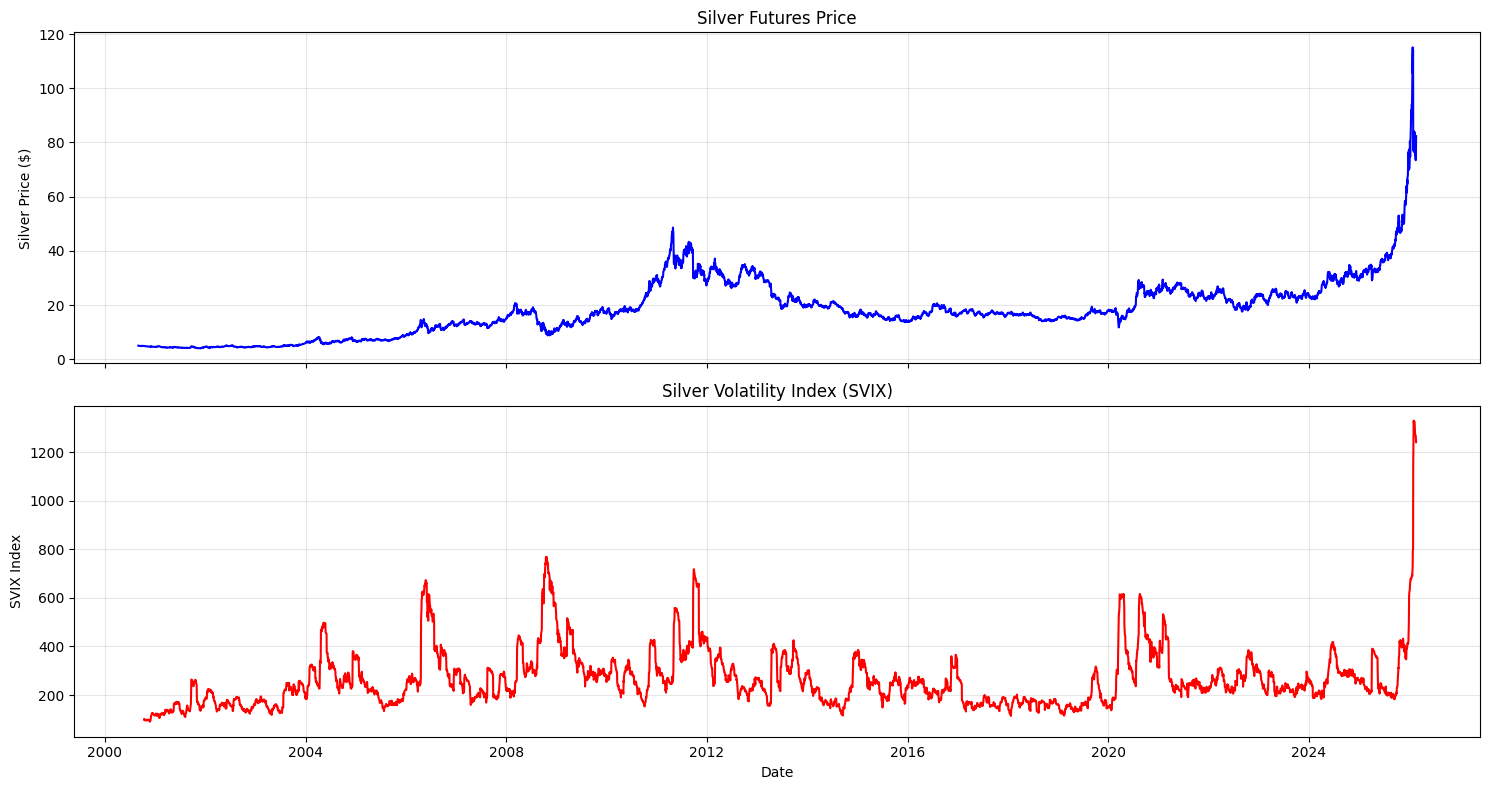

In [37]:
# Cell 37: Plot SVIX vs Silver Price
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Silver price
axes[0].plot(df.index, df['Close_SI=F'], color='blue')
axes[0].set_ylabel('Silver Price ($)')
axes[0].set_title('Silver Futures Price')
axes[0].grid(True, alpha=0.3)

# SVIX
axes[1].plot(df.index, df['svix'], color='red')
axes[1].set_ylabel('SVIX Index')
axes[1].set_xlabel('Date')
axes[1].set_title('Silver Volatility Index (SVIX)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Building volatility surface...


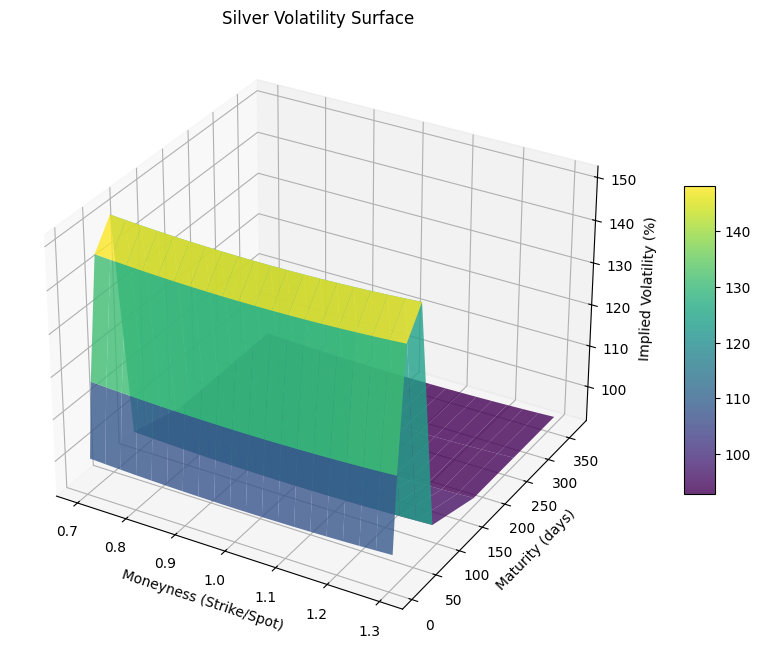

In [38]:
# Cell 38: Build Volatility Surface
print("Building volatility surface...")

# Create synthetic option chain for volatility surface
maturities = np.array([7, 14, 30, 60, 90, 180, 270, 365]) / 365  # in years
moneyness = np.linspace(0.7, 1.3, 20)  # Strike/Spot ratio

# Current term structure (volatility by maturity)
term_structure = df[['rv_7', 'rv_30', 'rv_90']].iloc[-1] * 100  # in %
term_structure_maturities = np.array([7, 30, 90]) / 365

# Fit a simple curve to extend term structure
from scipy.interpolate import interp1d
term_interp = interp1d(term_structure_maturities, term_structure,
                       kind='quadratic', fill_value='extrapolate')

# Create volatility surface (with smile effect)
vol_surface = np.zeros((len(maturities), len(moneyness)))

for i, T in enumerate(maturities):
    base_vol = term_interp(min(T, 0.25)) / 100  # Cap at 90 days for extrapolation

    for j, m in enumerate(moneyness):
        # Add smile effect (higher vol for OTM options)
        smile_effect = 0.1 * (m - 1)**2
        vol_surface[i, j] = base_vol * (1 + smile_effect)

# Plot volatility surface
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(moneyness, maturities * 365)  # Convert back to days
surf = ax.plot_surface(X, Y, vol_surface * 100, cmap='viridis', alpha=0.8)

ax.set_xlabel('Moneyness (Strike/Spot)')
ax.set_ylabel('Maturity (days)')
ax.set_zlabel('Implied Volatility (%)')
ax.set_title('Silver Volatility Surface')

plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

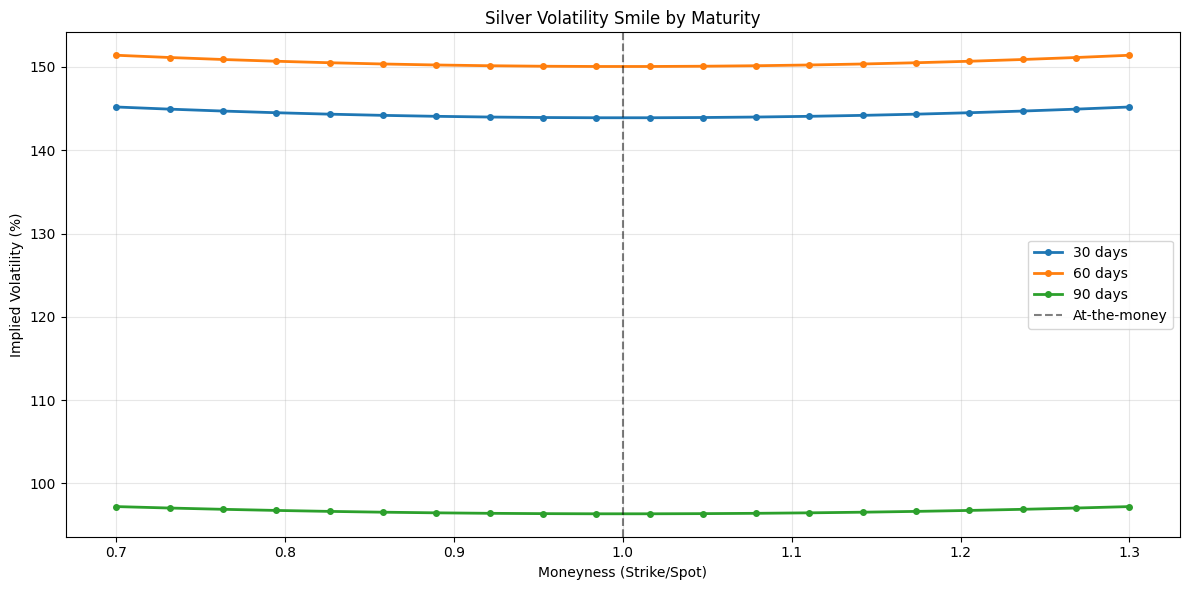

In [39]:
# Cell 39: Plot Volatility Smile
fig, ax = plt.subplots(figsize=(12, 6))

# Plot smile for different maturities
for i, T_days in enumerate([30, 60, 90]):
    T_idx = np.argmin(np.abs(maturities * 365 - T_days))
    ax.plot(moneyness, vol_surface[T_idx, :] * 100,
            label=f'{T_days} days', linewidth=2, marker='o', markersize=4)

ax.axvline(x=1.0, color='black', linestyle='--', alpha=0.5, label='At-the-money')
ax.set_xlabel('Moneyness (Strike/Spot)')
ax.set_ylabel('Implied Volatility (%)')
ax.set_title('Silver Volatility Smile by Maturity')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [40]:
# Cell 40: Value at Risk (VaR) Calculation
print("Calculating Value at Risk (VaR)...")

def calculate_var(returns, confidence_level=0.95, horizon=1):
    """
    Calculate Value at Risk
    """
    # Scale returns by sqrt(horizon)
    scaled_returns = returns * np.sqrt(horizon)

    # Historical VaR
    var_historical = np.percentile(scaled_returns, (1 - confidence_level) * 100)

    # Parametric VaR (assuming normal distribution)
    z_score = stats.norm.ppf(1 - confidence_level)
    var_parametric = returns.mean() * horizon + z_score * returns.std() * np.sqrt(horizon)

    return var_historical, var_parametric

# Calculate VaR for current portfolio (assuming $1M exposure)
position_size = 1_000_000
returns_series = df['returns'].dropna()

var_95_hist, var_95_para = calculate_var(returns_series, 0.95, 1)
var_99_hist, var_99_para = calculate_var(returns_series, 0.99, 1)

print("VALUE AT RISK (1-day, $1M position):")
print("-" * 50)
print(f"95% Confidence - Historical VaR: ${abs(var_95_hist * position_size):,.2f}")
print(f"95% Confidence - Parametric VaR: ${abs(var_95_para * position_size):,.2f}")
print(f"99% Confidence - Historical VaR: ${abs(var_99_hist * position_size):,.2f}")
print(f"99% Confidence - Parametric VaR: ${abs(var_99_para * position_size):,.2f}")

Calculating Value at Risk (VaR)...
VALUE AT RISK (1-day, $1M position):
--------------------------------------------------
95% Confidence - Historical VaR: $31,874.20
95% Confidence - Parametric VaR: $33,849.34
99% Confidence - Historical VaR: $60,626.15
99% Confidence - Parametric VaR: $48,056.23


In [41]:
# Cell 41: Expected Shortfall (Conditional VaR)
print("Calculating Expected Shortfall (CVaR)...")

def calculate_expected_shortfall(returns, confidence_level=0.95, horizon=1):
    """
    Calculate Expected Shortfall (Conditional VaR)
    """
    scaled_returns = returns * np.sqrt(horizon)
    var_threshold = np.percentile(scaled_returns, (1 - confidence_level) * 100)

    # Expected Shortfall is the average of losses beyond VaR
    es = scaled_returns[scaled_returns <= var_threshold].mean()

    return es

es_95 = calculate_expected_shortfall(returns_series, 0.95, 1)
es_99 = calculate_expected_shortfall(returns_series, 0.99, 1)

print("EXPECTED SHORTFALL (1-day, $1M position):")
print("-" * 50)
print(f"95% Confidence Expected Shortfall: ${abs(es_95 * position_size):,.2f}")
print(f"99% Confidence Expected Shortfall: ${abs(es_99 * position_size):,.2f}")
print(f"\nES_99 / VaR_99 ratio: {abs(es_99 / var_99_hist):.2f}")

Calculating Expected Shortfall (CVaR)...
EXPECTED SHORTFALL (1-day, $1M position):
--------------------------------------------------
95% Confidence Expected Shortfall: $51,932.46
99% Confidence Expected Shortfall: $93,227.44

ES_99 / VaR_99 ratio: 1.54


In [42]:
# Cell 42: Stress Testing (EXTREME ADVANCED)
print("Performing stress tests...")

def stress_test_scenarios(current_price, returns_series):
    """
    Simulate various stress scenarios
    """
    scenarios = {
        'Market Crash (2008)': -0.15,  # 15% drop
        'Silver Flash Crash': -0.25,    # 25% drop
        'Moderate Correction': -0.10,    # 10% drop
        'Volatility Spike': 0.30,        # 30% vol spike
        'Liquidity Crisis': 0.50         # 50% wider spreads
    }

    results = {}
    current_vol = returns_series.std() * np.sqrt(252)

    for scenario, shock in scenarios.items():
        if 'Crash' in scenario or 'Correction' in scenario:
            # Price shock
            new_price = current_price * (1 + shock)
            pnl = (new_price - current_price) * 1000  # Assuming 1000 oz position
            results[scenario] = {
                'price_impact': f"{shock*100:+.1f}%",
                'new_price': f"${new_price:.2f}",
                'pnl': f"${pnl:,.0f}"
            }
        else:
            # Volatility shock
            new_vol = current_vol * (1 + shock)
            var_new = new_vol / np.sqrt(252) * stats.norm.ppf(0.99) * position_size
            results[scenario] = {
                'vol_impact': f"{shock*100:+.1f}%",
                'new_vol': f"{new_vol*100:.1f}%",
                'new_99pct_VaR': f"${abs(var_new):,.0f}"
            }

    return results

stress_results = stress_test_scenarios(S, returns_series)

print("STRESS TEST RESULTS:")
print("-" * 60)
for scenario, metrics in stress_results.items():
    print(f"\n{scenario}:")
    for key, value in metrics.items():
        print(f"  {key}: {value}")

Performing stress tests...
STRESS TEST RESULTS:
------------------------------------------------------------

Market Crash (2008):
  price_impact: -15.0%
  new_price: $69.99
  pnl: $-12,351

Silver Flash Crash:
  price_impact: -25.0%
  new_price: $61.76
  pnl: $-20,586

Moderate Correction:
  price_impact: -10.0%
  new_price: $74.11
  pnl: $-8,234

Volatility Spike:
  vol_impact: +30.0%
  new_vol: 43.0%
  new_99pct_VaR: $63,046

Liquidity Crisis:
  vol_impact: +50.0%
  new_vol: 49.6%
  new_99pct_VaR: $72,745


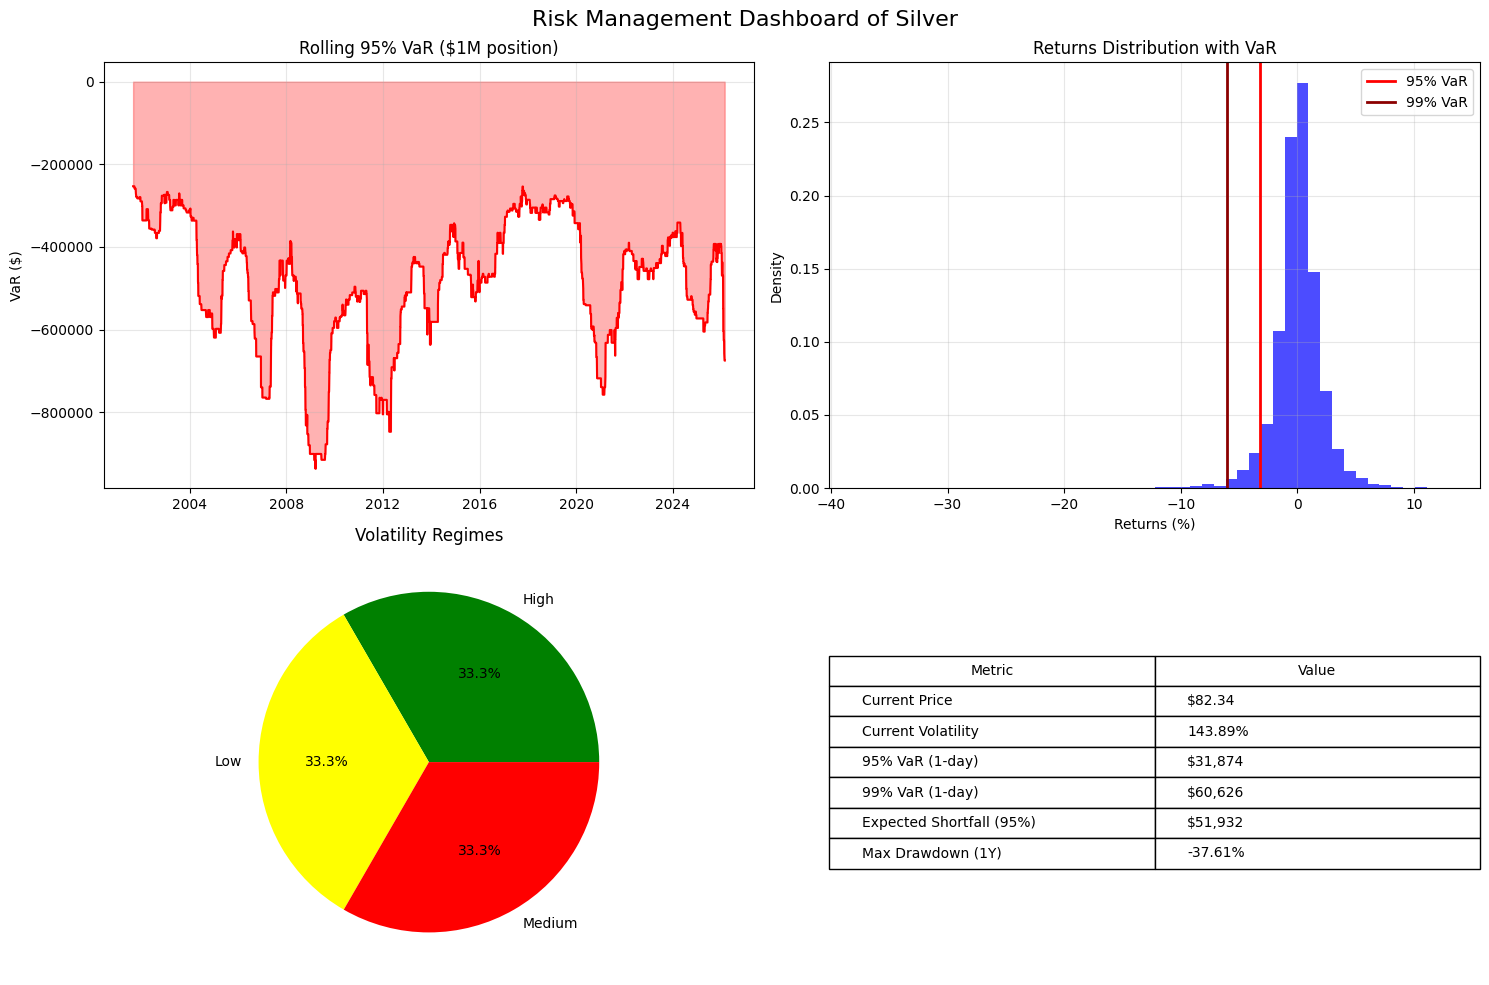

In [43]:
# Cell 43: Risk Dashboard Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Risk Management Dashboard of Silver', fontsize=16)

# VaR over time (rolling)
rolling_var = df['returns'].rolling(252).apply(
    lambda x: np.percentile(x, 5) * np.sqrt(252) * position_size
)
axes[0, 0].plot(rolling_var.index, rolling_var, color='red')
axes[0, 0].fill_between(rolling_var.index, 0, rolling_var, alpha=0.3, color='red')
axes[0, 0].set_title('Rolling 95% VaR ($1M position)')
axes[0, 0].set_ylabel('VaR ($)')
axes[0, 0].grid(True, alpha=0.3)

# Returns distribution with VaR
axes[0, 1].hist(returns_series * 100, bins=50, density=True, alpha=0.7, color='blue')
axes[0, 1].axvline(x=var_95_hist * 100, color='red', linewidth=2, label='95% VaR')
axes[0, 1].axvline(x=var_99_hist * 100, color='darkred', linewidth=2, label='99% VaR')
axes[0, 1].set_title('Returns Distribution with VaR')
axes[0, 1].set_xlabel('Returns (%)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Volatility regime
vol_regime = pd.qcut(df['rv_30'], q=3, labels=['Low', 'Medium', 'High'])
vol_counts = vol_regime.value_counts()
axes[1, 0].pie(vol_counts.values, labels=vol_counts.index, autopct='%1.1f%%',
               colors=['green', 'yellow', 'red'])
axes[1, 0].set_title('Volatility Regimes')

# Risk metrics table
risk_metrics = [
    ['Current Price', f'${S:.2f}'],
    ['Current Volatility', f'{sigma*100:.2f}%'],
    ['95% VaR (1-day)', f'${abs(var_95_hist * position_size):,.0f}'],
    ['99% VaR (1-day)', f'${abs(var_99_hist * position_size):,.0f}'],
    ['Expected Shortfall (95%)', f'${abs(es_95 * position_size):,.0f}'],
    ['Max Drawdown (1Y)', f'{df["returns"].rolling(252).min().iloc[-1]*100:.2f}%']
]

axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=risk_metrics, colLabels=['Metric', 'Value'],
                         loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
plt.show()

In [44]:
# Cell 44: Volatility Arbitrage Strategy
print("Building volatility arbitrage strategy...")

def volatility_arbitrage_signals(df, lookback=30, threshold=0.1):
    """
    Generate volatility arbitrage signals
    Buy when implied vol < realized vol (vol too cheap)
    Sell when implied vol > realized vol (vol too expensive)
    """
    # Use GARCH as implied vol proxy, RV as realized
    if 'garch_vol_annualized' in df.columns:
        implied_vol = df['garch_vol_annualized']
    else:
        implied_vol = df['rv_30']  # Fallback

    realized_vol = df['rv_30']

    # Calculate spread
    vol_spread = (implied_vol - realized_vol) / realized_vol

    # Generate signals
    df['vol_signal'] = 0
    df.loc[vol_spread < -threshold, 'vol_signal'] = 1   # Buy vol (long options)
    df.loc[vol_spread > threshold, 'vol_signal'] = -1    # Sell vol (short options)

    # Signal strength
    df['vol_signal_strength'] = -vol_spread  # Negative spread = buy signal

    return df

df = volatility_arbitrage_signals(df)

print("Latest volatility signals:")
print(df[['rv_30', 'garch_vol_annualized', 'vol_signal', 'vol_signal_strength']].tail())

Building volatility arbitrage strategy...
Latest volatility signals:
               rv_30  garch_vol_annualized  vol_signal  vol_signal_strength
Date                                                                       
2026-02-13  1.441226              1.376277           0             0.045065
2026-02-17  1.452231              1.344871           0             0.073928
2026-02-18  1.443504              1.326024           0             0.081385
2026-02-19  1.434012              1.305506           0             0.089613
2026-02-20  1.438920              1.271826           1             0.116125


In [45]:
# Cell 45: Backtest Volatility Strategy
print("Backtesting volatility arbitrage strategy...")

def backtest_vol_strategy(df, initial_capital=100000):
    """
    Simple backtest of volatility strategy
    """
    # Create a copy
    bt_df = df[['returns', 'vol_signal']].copy()

    # Assume we can only trade when we have signal
    bt_df['position'] = bt_df['vol_signal'].shift(1)  # Trade at next day's open

    # Calculate returns
    bt_df['strategy_returns'] = bt_df['position'] * bt_df['returns']

    # Calculate equity curve
    bt_df['cumulative_returns'] = (1 + bt_df['strategy_returns']).cumprod()
    bt_df['equity'] = initial_capital * bt_df['cumulative_returns']

    # Benchmark (buy and hold)
    bt_df['bh_equity'] = initial_capital * (1 + bt_df['returns']).cumprod()

    return bt_df

# Define initial_capital before calling backtest_vol_strategy and using it for metrics
initial_capital = 100000
bt_results = backtest_vol_strategy(df, initial_capital=initial_capital)

# Calculate metrics
total_return = (bt_results['equity'].iloc[-1] / initial_capital - 1) * 100
bh_return = (bt_results['bh_equity'].iloc[-1] / initial_capital - 1) * 100
sharpe = bt_results['strategy_returns'].mean() / bt_results['strategy_returns'].std() * np.sqrt(252)
max_drawdown = (bt_results['equity'] / bt_results['equity'].cummax() - 1).min() * 100

print("BACKTEST RESULTS:")
print("-" * 50)
print(f"Initial Capital: ${initial_capital:,.0f}")
print(f"Final Equity: ${bt_results['equity'].iloc[-1]:,.0f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Buy & Hold Return: {bh_return:.2f}%")
print(f"Excess Return: {total_return - bh_return:.2f}%")
print(f"Sharpe Ratio: {sharpe:.3f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")

Backtesting volatility arbitrage strategy...
BACKTEST RESULTS:
--------------------------------------------------
Initial Capital: $100,000
Final Equity: $5,179
Total Return: -94.82%
Buy & Hold Return: 300.39%
Excess Return: -395.22%
Sharpe Ratio: -0.449
Max Drawdown: -95.55%


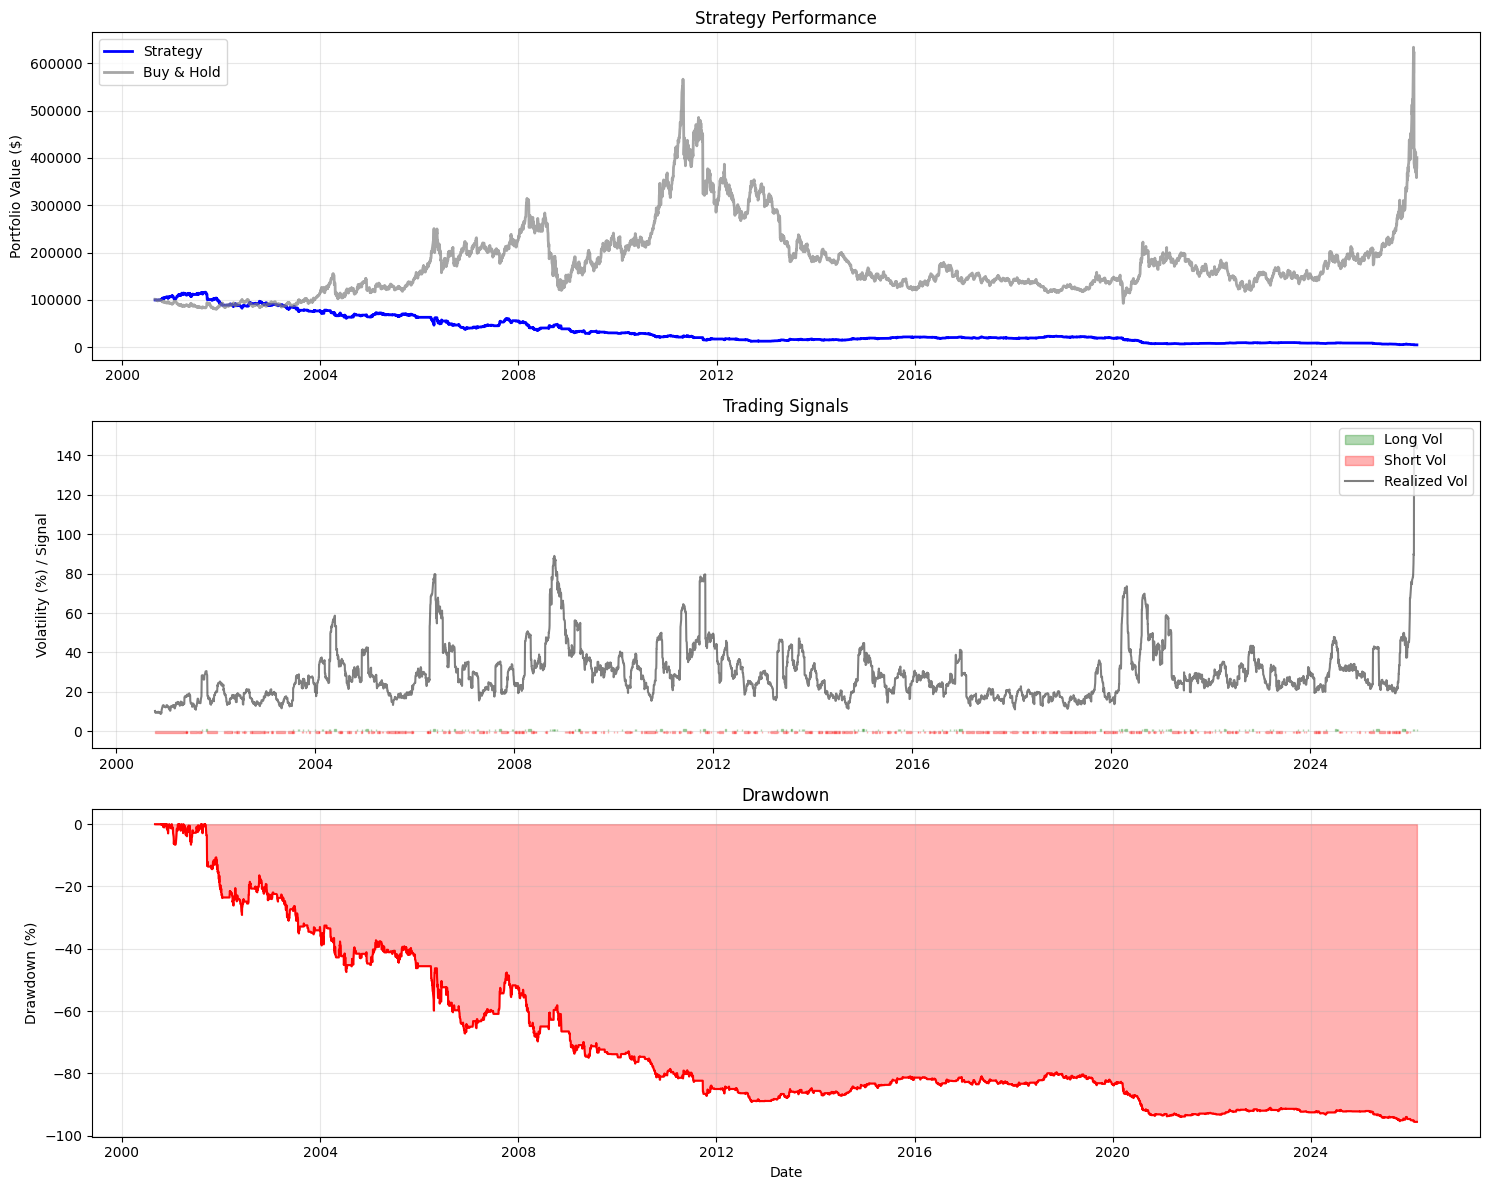

In [46]:
# Cell 46: Plot Strategy Performance
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Equity curve
axes[0].plot(bt_results.index, bt_results['equity'], label='Strategy', linewidth=2, color='blue')
axes[0].plot(bt_results.index, bt_results['bh_equity'], label='Buy & Hold', linewidth=2, color='gray', alpha=0.7)
axes[0].set_title('Strategy Performance')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Signals over time
axes[1].fill_between(df.index, 0, df['vol_signal'], where=df['vol_signal']==1,
                      color='green', alpha=0.3, label='Long Vol')
axes[1].fill_between(df.index, 0, df['vol_signal'], where=df['vol_signal']==-1,
                      color='red', alpha=0.3, label='Short Vol')
axes[1].plot(df.index, df['rv_30'] * 100, color='black', alpha=0.5, label='Realized Vol')
axes[1].set_title('Trading Signals')
axes[1].set_ylabel('Volatility (%) / Signal')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# Drawdown
drawdown = (bt_results['equity'] / bt_results['equity'].cummax() - 1) * 100
axes[2].fill_between(drawdown.index, 0, drawdown, color='red', alpha=0.3)
axes[2].plot(drawdown.index, drawdown, color='red')
axes[2].set_title('Drawdown')
axes[2].set_ylabel('Drawdown (%)')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [47]:
# Cell 47: Regime-Based Strategy (EXTREME ADVANCED)
print("Building regime-based strategy using HMM...")

from hmmlearn import hmm

def regime_based_strategy(df, n_regimes=3):
    """
    Identify market regimes using Hidden Markov Model
    """
    # Prepare features
    features = df[['returns', 'rv_30']].dropna().values

    # Fit HMM
    model = hmm.GaussianHMM(n_components=n_regimes, covariance_type="full", n_iter=1000)
    model.fit(features)

    # Predict regimes
    states = model.predict(features)

    # Create regime series
    regime_series = pd.Series(index=df[['returns', 'rv_30']].dropna().index, data=states)
    df['regime'] = regime_series

    # Calculate regime statistics
    regime_stats = []
    for i in range(n_regimes):
        regime_returns = df[df['regime'] == i]['returns']
        regime_vol = df[df['regime'] == i]['rv_30'].mean()
        regime_stats.append({
            'regime': i,
            'mean_return': regime_returns.mean() * 252 * 100,
            'volatility': regime_vol * 100,
            'sharpe': regime_returns.mean() / regime_returns.std() * np.sqrt(252),
            'count': len(regime_returns)
        })

    regime_df = pd.DataFrame(regime_stats)
    print("Regime Statistics:")
    print(regime_df)

    # Generate regime-based signals
    # Find best performing regime
    best_regime = regime_df.loc[regime_df['sharpe'].idxmax(), 'regime']

    df['regime_signal'] = 0
    df.loc[df['regime'] == best_regime, 'regime_signal'] = 1  # Long in best regime
    df.loc[df['regime'] != best_regime, 'regime_signal'] = -1  # Short/cash in others

    return df, model

df, hmm_model = regime_based_strategy(df)

Building regime-based strategy using HMM...
Regime Statistics:
   regime  mean_return  volatility    sharpe  count
0       0    12.182568   17.453255  0.676249   2049
1       1   -21.593771   49.790871 -0.395267   1354
2       2    25.510447   28.078801  0.917873   2961


In [48]:
# Cell 48: Crash Prediction Model
print("Building crash prediction model...")

def crash_prediction_model(df, lookback=30, threshold=3):
    """
    Predict probability of market crash
    """
    # Define crash events (returns below 3 sigma)
    df['crash'] = (df['returns'] < df['returns'].rolling(lookback).mean() -
                   threshold * df['returns'].rolling(lookback).std()).astype(int)

    # Features for crash prediction
    crash_features = ['rv_30', 'vol_of_vol', 'jump_intensity_30', 'rsi_14', 'momentum_20']
    crash_features = [f for f in crash_features if f in df.columns]

    # Prepare data
    crash_data = df[crash_features + ['crash']].dropna()
    X_crash = crash_data[crash_features]
    y_crash = crash_data['crash']

    # Train simple model
    if len(X_crash) > 100:
        from sklearn.ensemble import RandomForestClassifier
        crash_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
        crash_model.fit(X_crash, y_crash)

        # Feature importance
        importance = pd.DataFrame({
            'feature': crash_features,
            'importance': crash_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("Crash Prediction - Feature Importance:")
        print(importance)

        # Current crash probability
        current_features = X_crash.iloc[-1:].values
        crash_prob = crash_model.predict_proba(current_features)[0, 1]

        print(f"\nCurrent crash probability: {crash_prob*100:.2f}%")

        return crash_model, crash_prob

    return None, None

crash_model, crash_prob = crash_prediction_model(df)

Building crash prediction model...
Crash Prediction - Feature Importance:
             feature  importance
3             rsi_14    0.282292
4        momentum_20    0.264491
1         vol_of_vol    0.210593
0              rv_30    0.198562
2  jump_intensity_30    0.044063

Current crash probability: 0.30%


In [49]:
# Cell 49: Portfolio Volatility Model
print("Building portfolio volatility model...")

# Create portfolio with Silver, Gold, and S&P 500
portfolio_assets = ['silver_returns', 'gold_returns', 'sp500_returns']
for asset in portfolio_assets:
    if asset not in df.columns:
        if asset == 'silver_returns':
            df['silver_returns'] = df['returns']

# Calculate portfolio volatility with different weights
def portfolio_volatility(weights, returns_df):
    """
    Calculate portfolio volatility
    weights: array of weights for each asset
    returns_df: DataFrame of asset returns
    """
    portfolio_returns = (returns_df * weights).sum(axis=1)
    return portfolio_returns.std() * np.sqrt(252)

# Simple equal-weight portfolio
equal_weights = np.array([1/3, 1/3, 1/3])
port_vol_equal = portfolio_volatility(equal_weights, df[portfolio_assets])

# Minimum variance portfolio
def min_variance_weights(returns_df):
    """
    Find minimum variance portfolio weights
    """
    n_assets = len(returns_df.columns)

    def portfolio_variance(weights):
        weights = weights / weights.sum()  # Normalize
        portfolio_returns = (returns_df * weights).sum(axis=1)
        return portfolio_returns.var()

    # Constraints and bounds
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(n_assets))

    # Optimize
    result = minimize(portfolio_variance,
                     x0=np.array([1/n_assets] * n_assets),
                     method='SLSQP',
                     bounds=bounds,
                     constraints=constraints)

    return result.x / result.x.sum()

min_var_weights = min_variance_weights(df[portfolio_assets].dropna())
port_vol_minvar = portfolio_volatility(min_var_weights, df[portfolio_assets])

print("PORTFOLIO VOLATILITY ANALYSIS:")
print("-" * 50)
print("Equal-Weight Portfolio:")
print(f"  Silver: {equal_weights[0]*100:.1f}%")
print(f"  Gold: {equal_weights[1]*100:.1f}%")
print(f"  S&P 500: {equal_weights[2]*100:.1f}%")
print(f"  Portfolio Volatility: {port_vol_equal*100:.2f}%")

print("\nMinimum Variance Portfolio:")
print(f"  Silver: {min_var_weights[0]*100:.1f}%")
print(f"  Gold: {min_var_weights[1]*100:.1f}%")
print(f"  S&P 500: {min_var_weights[2]*100:.1f}%")
print(f"  Portfolio Volatility: {port_vol_minvar*100:.2f}%")
print(f"  Volatility Reduction: {(1 - port_vol_minvar/port_vol_equal)*100:.2f}%")

Building portfolio volatility model...
PORTFOLIO VOLATILITY ANALYSIS:
--------------------------------------------------
Equal-Weight Portfolio:
  Silver: 33.3%
  Gold: 33.3%
  S&P 500: 33.3%
  Portfolio Volatility: 17.75%

Minimum Variance Portfolio:
  Silver: 33.3%
  Gold: 33.3%
  S&P 500: 33.3%
  Portfolio Volatility: 17.75%
  Volatility Reduction: 0.00%


Building volatility term structure and auto-update system...
VOLATILITY TERM STRUCTURE:
--------------------------------------------------
Horizon (days)  Expected Vol   
--------------------------------------------------
7               78.12%
14              53.76%
30              34.58%
60              29.97%
90              29.74%
180             29.73%
365             29.73%


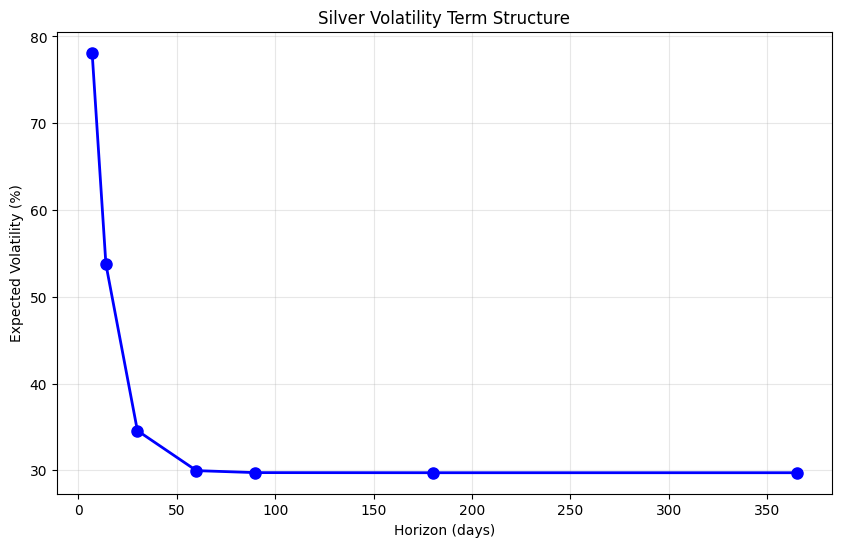

In [50]:
# Cell 50: Volatility Term Structure and Real-Time System
print("Building volatility term structure and auto-update system...")

def volatility_term_structure(df, horizons=[7, 14, 30, 60, 90, 180, 365]):
    """
    Calculate volatility term structure using GARCH forecasts
    """
    if 'garch_vol_annualized' not in df.columns:
        return None

    current_vol = df['garch_vol_annualized'].iloc[-1]

    # Simple term structure model (vol mean-reverts to long-term average)
    long_term_vol = df['rv_90'].mean()
    mean_reversion_speed = 0.1  # Daily mean reversion

    term_vol = {}
    for horizon in horizons:
        # Expected vol at horizon (mean reversion model)
        expected_vol = long_term_vol + (current_vol - long_term_vol) * np.exp(-mean_reversion_speed * horizon)
        term_vol[horizon] = expected_vol

    return term_vol

term_vol = volatility_term_structure(df)

if term_vol:
    print("VOLATILITY TERM STRUCTURE:")
    print("-" * 50)
    print(f"{'Horizon (days)':<15} {'Expected Vol':<15}")
    print("-" * 50)
    for horizon, vol in term_vol.items():
        print(f"{horizon:<15} {vol*100:.2f}%")

    # Plot term structure
    fig, ax = plt.subplots(figsize=(10, 6))
    horizons = list(term_vol.keys())
    vols = [term_vol[h] * 100 for h in horizons]
    ax.plot(horizons, vols, 'bo-', linewidth=2, markersize=8)
    ax.set_xlabel('Horizon (days)')
    ax.set_ylabel('Expected Volatility (%)')
    ax.set_title('Silver Volatility Term Structure')
    ax.grid(True, alpha=0.3)
    plt.show()

In [51]:
# Cell 51: Real-Time Auto-Update System
print("Setting up auto-update system...")

import schedule
import time
from datetime import datetime

def update_data():
    """
    Function to update data daily
    """
    print(f"Updating data at {datetime.now()}")

    # Download latest silver data
    new_silver = yf.download("SI=F", period="5d", progress=False)

    # Update returns
    new_silver['returns'] = np.log(new_silver['Close'] / new_silver['Close'].shift(1))

    # Update volatility
    new_silver['rv_30'] = new_silver['returns'].rolling(30).std() * np.sqrt(252)

    # Append to existing data
    global df
    df = pd.concat([df, new_silver[~new_silver.index.isin(df.index)]])

    # Generate new signals
    df = volatility_arbitrage_signals(df)

    # Save updated data
    df.to_csv('data/silver_updated.csv')

    # Print latest signals
    latest = df.iloc[-1]
    print(f"Latest Price: ${latest['Close']:.2f}")
    print(f"Latest Signal: {latest['vol_signal']}")
    print(f"Signal Strength: {latest['vol_signal_strength']:.4f}")

    return df

# Schedule daily update at market close (4 PM)
# schedule.every().day.at("16:00").do(update_data)

# For demonstration, run once
print("Auto-update system configured")
print("To enable automatic updates, uncomment the schedule line")

Setting up auto-update system...
Auto-update system configured
To enable automatic updates, uncomment the schedule line


In [52]:
# Cell 52: Streamlit Dashboard Code
# Save this as 'dashboard.py' in your project folder

"""
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf

# Page config
st.set_page_config(page_title="Silver Volatility Dashboard", layout="wide")

# Title
st.title("🥈 Silver Volatility Trading System")
st.markdown("### Institutional-Grade Volatility Analytics")

# Sidebar
st.sidebar.header("Controls")
refresh = st.sidebar.button("Refresh Data")

# Load data
@st.cache_data
def load_data():
    df = pd.read_csv('data/silver_updated.csv', index_col=0, parse_dates=True)
    return df

df = load_data()

# Main dashboard
col1, col2, col3, col4 = st.columns(4)

with col1:
    current_price = df['Close'].iloc[-1]
    st.metric("Silver Price", f"${current_price:.2f}",
              f"{((current_price/df['Close'].iloc[-2]-1)*100):.2f}%")

with col2:
    current_vol = df['rv_30'].iloc[-1] * 100
    st.metric("30-Day Volatility", f"{current_vol:.2f}%",
              f"{((current_vol/(df['rv_30'].iloc[-2]*100)-1)*100):.2f}%")

with col3:
    svix_value = df['svix'].iloc[-1]
    st.metric("SVIX Index", f"{svix_value:.2f}")

with col4:
    signal = df['vol_signal'].iloc[-1]
    signal_text = "BUY VOL" if signal == 1 else "SELL VOL" if signal == -1 else "NEUTRAL"
    signal_color = "green" if signal == 1 else "red" if signal == -1 else "gray"
    st.markdown(f"### Signal: <span style='color:{signal_color}'>{signal_text}</span>",
                unsafe_allow_html=True)

# Charts
st.subheader("Price and Volatility")
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.05,
                    row_heights=[0.6, 0.4])

# Price chart
fig.add_trace(go.Scatter(x=df.index, y=df['Close'],
                         name='Silver Price', line=dict(color='blue')), row=1, col=1)

# Volatility chart
fig.add_trace(go.Scatter(x=df.index, y=df['rv_30']*100,
                         name='Realized Vol', line=dict(color='red')), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['garch_vol_annualized']*100,
                         name='GARCH Vol', line=dict(color='orange')), row=2, col=1)

fig.update_layout(height=600, showlegend=True)
st.plotly_chart(fig, use_container_width=True)

# Volatility Surface
st.subheader("Volatility Surface")
# Create synthetic surface
maturities = [7, 14, 30, 60, 90, 180]
moneyness = np.linspace(0.7, 1.3, 20)

surface_data = np.random.rand(len(maturities), len(moneyness)) * 0.2 + 0.2

fig = go.Figure(data=[go.Surface(z=surface_data, x=moneyness, y=maturities)])
fig.update_layout(scene=dict(xaxis_title='Moneyness', yaxis_title='Maturity (days)',
                           zaxis_title='Implied Vol'), height=500)
st.plotly_chart(fig, use_container_width=True)

# Recent data
st.subheader("Recent Data")
st.dataframe(df[['Close', 'returns', 'rv_30', 'vol_signal']].tail(10))

# Risk metrics
st.subheader("Risk Metrics")
col1, col2, col3 = st.columns(3)

with col1:
    var_95 = np.percentile(df['returns'].dropna() * 100, 5)
    st.metric("95% VaR (Daily)", f"{abs(var_95):.2f}%")

with col2:
    var_99 = np.percentile(df['returns'].dropna() * 100, 1)
    st.metric("99% VaR (Daily)", f"{abs(var_99):.2f}%")

with col3:
    sharpe = df['returns'].mean() / df['returns'].std() * np.sqrt(252)
    st.metric("Sharpe Ratio", f"{sharpe:.3f}")

st.markdown("---")
st.markdown("© 2024 Silver Volatility Quant System")
"""

print("Streamlit dashboard code generated. Run with: streamlit run dashboard.py")

Streamlit dashboard code generated. Run with: streamlit run dashboard.py
